# CAB420, Regression, Example 2: Regularised Regression
Dr Simon Denman (s.denman@qut.edu.au)

## Overview
In this example, we'll explore:
* A quick recap of linear regression, and linear regression using lots of data, and lots of variables
* L1 (Lasso) regression
* L2 (ridge) regression

## Too Long; Didn't Read
* Linear regression can become challenging when we have a lot of variables. In particular, tuning the model can become hard due to the sheer volume of variables which require inspection. Models are also more likely to overfit in such scenarios.
* Regularisation is a process that applies a small penalty to the model, such that simpler models are favoured. In the case of regression, a simpler model is considered to be one with smaller and/or fewer weights.
* Ridge uses L2 regularisation, which is the sum of the squares of the coefficients, to regularise the model. This approach can supress, but not eliminate terms.
* Lasso uses L1 regularisation, which is the sum of the absolute value of the coefficients, to regularise the model. This approach can allow the regularisation to remove terms for the model entirely
* Often when fitting data, we may wish to standardise the data first. Standardising involves subtracting the mean, and dividing by the standard deviation for each dimension. The end result is that all dimensions have 0 mean and 1 standard deviation. This means that all have the same scale, which can lead to an improved fit and better visualisation of lasso and ridge traces.
* p-values don't exist for ridge and lasso, but our other evaluation tools such as qqplots and $R^2$ values still work. Remember to only calculate things like this on the training data.

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

## The Data
For data we'll use travel time data from Brisbane roads. This data contains average travel time over 15 minute intervals along key transport corridors. For simplicity, the data has already been aggregrated into one hour intervals, and all files merged. The original data can be found [here](https://www.data.qld.gov.au/dataset/travel-times-for-key-priority-routes).

Each row of our data contains a timestamp that indicates the end of the sampling interval, and a series of values for travel corridors in Brisbane. Each of these values represents the average travel time along that corridor in the past hour.

We'll start by loading our data, and dropping rows that contain NaNs (i..e missing data). We'll take the first 9 columns, and the 33rd. The 33rd will be our response. More on why I'm using that column in a little while.

In [2]:
data = pandas.read_csv('../data/BrisbaneData/Bluetooth_hourly_full.csv')
data_to_use = data.iloc[:, list(range(0, 9)) + [32]].dropna()
print(data_to_use.shape)

(11087, 10)


As a sanity check, we'll have a look at the data. Here, we're using:
* head, to print the first few rows
* describe, to print some stats about the data

In [3]:
print(data_to_use.head(10))
data_to_use.describe()

              INTERVAL_END  x_1098__1056_  x_1058__1059_  x_1057__1056_  \
0   01/07/2016 12:00:00 AM        98.9900        70.2250        56.7000   
1   01/07/2016 01:00:00 AM       105.0500        75.5675        54.6400   
4   01/07/2016 04:00:00 AM       100.1100        69.6125        54.5775   
5   01/07/2016 05:00:00 AM       103.7875        77.6125        66.1925   
6   01/07/2016 06:00:00 AM       115.1375        90.5425        60.0875   
7   01/07/2016 07:00:00 AM       141.3975        88.2150        60.9850   
8   01/07/2016 08:00:00 AM       172.2625        91.5725        64.6425   
9   01/07/2016 09:00:00 AM       184.7125        84.4000        73.3400   
10  01/07/2016 10:00:00 AM       294.5600       108.5450        92.7975   
11  01/07/2016 11:00:00 AM       269.7025       109.9800       101.2125   

    x_1017__1007_  x_1115__1015_  x_1015__1115_  x_1103__1061_  x_1135__1231_  \
0      177.000000        53.3700      42.740000        61.5625        21.9125   
1      180.4

,x_1098__1056_,x_1058__1059_,x_1057__1056_,x_1017__1007_,x_1115__1015_,x_1015__1115_,x_1103__1061_,x_1135__1231_,x_1059__1060_
count,11087.000000,11087.000000,11087.000000,11087.000000,11087.000000,11087.000000,11087.000000,11087.000000,11087.000000
mean,160.410026,102.903740,82.741177,190.431215,50.771036,46.085713,94.903804,32.246825,205.810907
std,72.492346,47.168211,24.560616,77.367461,22.645090,10.584571,32.721886,25.059277,84.245746
min,81.000000,59.843333,35.952500,156.670000,38.162500,20.850000,28.080000,3.480000,104.330000
25%,108.115000,81.200000,64.715000,172.756250,45.002500,41.686250,73.166250,23.652500,158.255000
50%,137.002500,92.735000,76.567500,178.255000,46.582500,42.627500,85.367500,24.500000,176.582500
75%,186.793750,102.177500,94.201250,183.793750,47.617500,46.788750,111.057500,26.395000,208.935000
max,805.845000,621.352500,442.857500,2929.447500,728.000000,417.865000,426.975000,379.840000,1132.760000


### Data Exploration and Pre-Processing

One limitation of the data in this format is that our intersection names are a bit meaningless, x_1057__1056_ doesn't really tell us much. We have another file that contains details of the corridors, so let's pull out data from that just so that we can tell what we're looking at.

Note that this data uses a different format for the corridor names, x_1057__1056_ becomes 1057->1056, so we'll need to clean up our column names if we want to do this at least somewhat automatically (which we do).

In [4]:
# NOTE: This bit of code is not really all that important, it's just to help explore the data
# load the data
data_details = pandas.read_csv('../data/BrisbaneData/priority-route-link-details-october-2021.csv')

# setup the bits of text in each key that we need to change to get our format switched over 
text_to_change = {'x_' : '', '__' : '->', '_': ''}
# simple function to do the conversion, we could use a lambda function here too
def replace_all(input_string, text_to_change):
    for k, v in text_to_change.items():
        input_string = input_string.replace(k, v)
    return input_string

# pull out and convert the intersection names
intersection_names = [replace_all(s, text_to_change) for s in data_to_use.columns[1:]]

# pull out those intersections from the table
# This line is a bit odd, so some details
#  - At this point, intersection_names names looks like this: ['1098->1056', '1058->1059', '1057->1056', '1017->1007', '1115->1015', '1015->1115', '1103->1061', '1135->1231', '1260->1261']
#  - We want to find intersections which match any one of these, i.e. '1098->1056' or '1058->1059' or '1057->1056' or .....
#  - To do this, we'll use a simple regular expression operating over the pandas data series (https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html)
#  - We'll concatenate each of our intersection_names, and put an | in between them, where | denotes or in the regex, so our string
#    will look somehting like '1098->1056|1058->1059|1057->1056......'
#  - The 'contains' function will then seek to match the regex, and as our regex is just a collection of names we're interested in
#    with an | in between, if the name is any one of those that we care about it will be found
#  - et viola, we have a filtered list
#
# Now we could do this other ways, a loop could work (though would be more code), and a list comprehension could also work
# (but would probably be fairly ugly looking) - both would be valid options here too.
#
intersection_details = data_details.where(data_details['LINK_DETAILS'].str.contains('|'.join(intersection_names))).dropna()
intersection_details

,LINK_DETAILS,ORIGIN_DESC,ORIGIN_LONGITUDE,ORIGIN_LATITUDE,DEST_DESC,DEST_LONGITUDE,DEST_LATITUDE
3,1015->1115,Bruce Highway and Dohles Rocks Road Northbound...,153.018289,-27.276611,Bruce Highway Murrumba Downs VMS (MET001),153.018229,-27.265953
33,1135->1231,CCTV1406 Pacific Motorway at Hawthorne Street,153.032469,-27.487992,South of Captain Cook Bridge (CS25),153.030813,-27.482910
50,1057->1056,Intersection Gympie and Hamilton Roads (M1116),153.030897,-27.385892,Intersection Gympie and Rode Roads (M1113),153.030954,-27.393409
108,1017->1007,At Boundary Road Interchange (M7084),152.991910,-27.211420,Bruce Highway near Anzac Ave Interchange,153.016018,-27.245606
110,1103->1061,Sandgate Road Interection with Toombul Shoppin...,153.059800,-27.409040,Intersection of Sandgate Road and Junction Roa...,153.058345,-27.415987
168,1098->1056,Intersection of Gympie Road and Sadlier Street...,153.032472,-27.406837,Intersection Gympie and Rode Roads (M1113),153.030954,-27.393409
169,1059->1060,Intersection Gympie/Albany Creek/Robinson Rds ...,153.017151,-27.364449,Intersection of Gympie and Beams Roads (M1132),153.012445,-27.345904
170,1115->1015,Bruce Highway Murrumba Downs VMS (MET001),153.018229,-27.265953,Bruce Highway and Dohles Rocks Road Northbound...,153.018289,-27.276611
193,1058->1059,Intersection Gympie and Webster Roads (M1119),153.023189,-27.373478,Intersection Gympie/Albany Creek/Robinson Rds ...,153.017151,-27.364449


Above we have our intersections - note that these are not in the same order as they are in the columns in our main data table.

We can see that they are mostly on the north side of the city, but they are not all in one nice little patch of Brisbane (though a bunch are on Gympie Road). For our modelling, this information is not really critical, but it might help explain some of what we observe later on. Let's say we're going to try to predict our last entry in that list (1058->1059, starting at the intersection of Gympie and Webster roads). Other intersections on Gympie road are likely to have a far greater influence than the counter on the Pacific Mototway, which is on the NSW side (i.e. the wrong side) of the river. Having additional knowledge of our predictors can help us make sense of what we see later on.

We could also use a variety of plots to help explore the data. We'll use two types of plot:
* A line plot of each series, just to get a feel for what's in the data
* A box plot, to get a summary of data structure

Note that in both of these plots I'm omitting the first column (the end of the time interval).

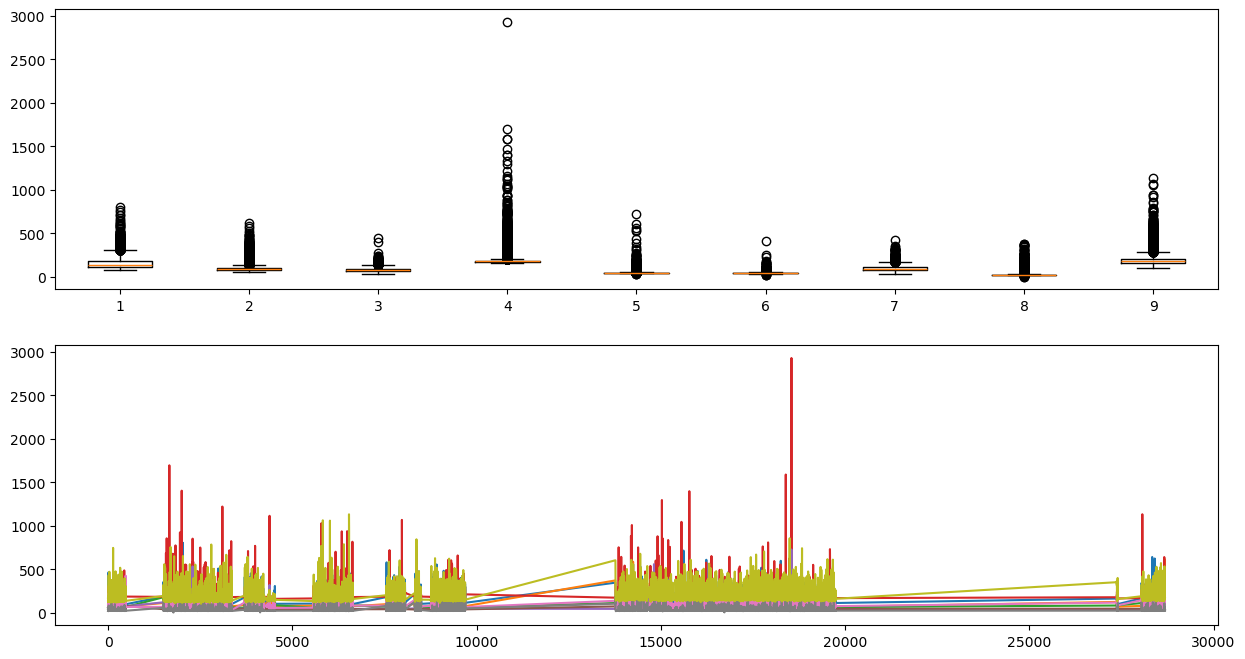

In [5]:
fig = plt.figure(figsize=[15, 8])
ax = fig.add_subplot(2, 1, 1)
ax.boxplot(data_to_use.iloc[:,1:]);
ax = fig.add_subplot(2, 1, 2)
ax.plot(data_to_use.iloc[:,1:]);

From the box plot we can see:
* Most data samples lie within a small range for each series
* All series have a fair number of outliers, all on the high side of things. This makes sense, and would represent peak hour traffic and when there are accidents, or bad weather. We have very few, if any outliers on the low side as there is a definite lower limit to how fast you can traverse any of the routes.

The line plot shows similar things, but we also have these large gaps in the plot. This looks like an error in the data, but is in fact just down to the way that pandas handles the table index. After we removed the nans (way back at the top), we didn't change the index. If we looked at the rows, we would see that the index (the left most column) skips some numbers - these are rows that were dropped. 

We can use reset_index to re-number the rows and this will make our plot look more as expected. Note that I'm using drop=True in this call, to prevent pandas from inserting a new column (index) into the table with the original indicies. Sometimes however you may want this, but I don't want it here.

In [6]:
data_to_use.reset_index(inplace=True, drop=True)

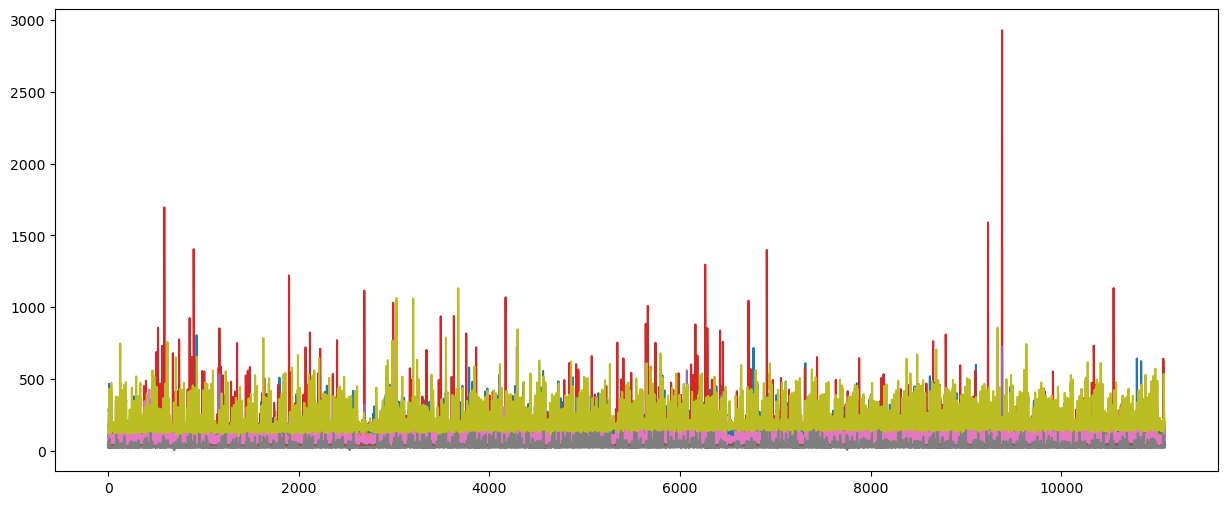

In [7]:
fig = plt.figure(figsize=[15, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(data_to_use.iloc[:,1:]);

Our plot now contains no missing data, as we can get a sense of what our data looks like (though plotting this as individual data series would be clearer, we're only trying to get a sense of the data here, so it's not critical). That said, you could argue that it makes sense to leave the index as it was, as it allows you to understand where rows have been removed and the plot helps us visualise how much data has been lost. However, there may be cases where you need to reset the index to make later operations easier.

One thing we can clearly see here is that each series has it's own floor which would be closely linked to the physical distance between the points being measured. This is potentially an issue later on as this scale can impact the values learned for our regression when we apply regularisation.

#### Timestamps

Let's now deal with the timestamp column. We can convert the whole column to a datetime type using pandas. From here, we can manipulate these as dates and times. For our purposes, we really don't .need to do anything fancy. All we'll do is pull out all the hours, and we can use this as a categorical variable in our model so our model can have some concept of time of day. We could do something similar with day of the week so the model understands weekdays and weekends, but we'll leave that as something that you could do in your own time if you're interested

In [8]:
dt = pandas.to_datetime(data_to_use.iloc[:,0], format="%d/%m/%Y %I:%M:%S %p")
hours = [d.hour for d in dt]
data_to_use.iloc[:,0] = hours
print(data_to_use.head(10))

  INTERVAL_END  x_1098__1056_  x_1058__1059_  x_1057__1056_  x_1017__1007_  \
0            0        98.9900        70.2250        56.7000     177.000000   
1            1       105.0500        75.5675        54.6400     180.443333   
2            4       100.1100        69.6125        54.5775     175.055000   
3            5       103.7875        77.6125        66.1925     178.212500   
4            6       115.1375        90.5425        60.0875     180.615000   
5            7       141.3975        88.2150        60.9850     178.405000   
6            8       172.2625        91.5725        64.6425     179.200000   
7            9       184.7125        84.4000        73.3400     183.095000   
8           10       294.5600       108.5450        92.7975     182.455000   
9           11       269.7025       109.9800       101.2125     181.127500   

   x_1115__1015_  x_1015__1115_  x_1103__1061_  x_1135__1231_  x_1059__1060_  
0        53.3700      42.740000        61.5625        21.9125 

We can see that we've replaced that column of strings with numbers. Now we need to convert the data to a categorical. 

In this example, we're going to do things a bit differently. I'm not going to use the formula API, so I need to create dummy columns for the categoricals, and merge this with the main table. This means that rather than have one column for the categorical, I'll have 23 (number of possible options, 24, minus 1). I'll do this by:
* create 23 dummy columns. Each column will be 1 or 0. If all columns are 0, it means that the 24th class is effectivley 1
* merge these 23 columns with the rest of data
* add a constant term (to learn the intercept) to the data frame

At the same time we're doing this, we'll split the data into X (predictors) and Y (response) variables. Our response is going to the be the last of our predictors (x_1059__1060_) which is one of our Gympie road sites.

In [9]:
dummies = pandas.get_dummies(data_to_use["INTERVAL_END"].astype("category"), drop_first=True)
X = pandas.concat([data_to_use.iloc[:,1:-1], dummies], axis=1).astype('float32')
X = sm.add_constant(X)
Y = data_to_use.iloc[:,-1]
print(X)
print(Y)

       const  x_1098__1056_  x_1058__1059_  x_1057__1056_  x_1017__1007_  \
0        1.0      98.989998      70.224998      56.700001     177.000000   
1        1.0     105.050003      75.567497      54.639999     180.443329   
2        1.0     100.110001      69.612503      54.577499     175.054993   
3        1.0     103.787498      77.612503      66.192497     178.212494   
4        1.0     115.137497      90.542503      60.087502     180.615005   
...      ...            ...            ...            ...            ...   
11082    1.0     139.117493     120.680000      78.592499     168.372498   
11083    1.0     122.089996     117.070000     105.675003     173.613327   
11084    1.0     112.320000     114.025002      61.807499     168.453339   
11085    1.0     108.392502     105.214996      69.160004     177.823334   
11086    1.0     102.230003      91.842499      53.533333     166.835007   

       x_1115__1015_  x_1015__1115_  x_1103__1061_  x_1135__1231_    1  ...  \
0       

## Data Splitting

We now need to split our data into:
* Train
* Validation
* Test

We'll use 70% for training, and 15% for testing and validation. We'll also just split the data sequentially (i.e. first 70% is train, etc).

In [10]:
num_samples = data_to_use.shape[0]
training_samples = int(num_samples*0.7)
validation_samples = int(num_samples*0.15)
X_train = X.iloc[0:training_samples, :]
Y_train = Y.iloc[0:training_samples]
X_val = X.iloc[training_samples:(training_samples + validation_samples), :]
Y_val = Y.iloc[training_samples:(training_samples + validation_samples)]
X_test = X.iloc[(training_samples + validation_samples):, :]
Y_test = Y.iloc[(training_samples + validation_samples):]

As a sanity check, we can print out the shape of the data sets to make sure that we didn't get something wrong.

In [11]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

(7760, 32)
(7760,)
(1663, 32)
(1663,)
(1664, 32)
(1664,)


Back at the top I mentioned there was a reason for picking the response that I did. Let's look at that reason by plotting a histogram of the response. Linear regression models have a lot of assumptions. One of them, is that our variables follow a Gaussian distribution. Looking at the below, our variable clearly doesn't (it more Possion than Gaussian), but it's not as bad as a bunch of other variables in this dataset that I could have selected. The response variable here has been at least somewhat chosen based on it being vaguely Gaussian, which will help the rest of our modelling.

If we wanted to actually account for the fact that our response is not Gaussian, then we'd use a Generalised Linear Model. These are out of scope for CAB420 - though there is a bonus example on them if you're keen.

Text(0.5, 1.0, 'Histogram of Response Values')

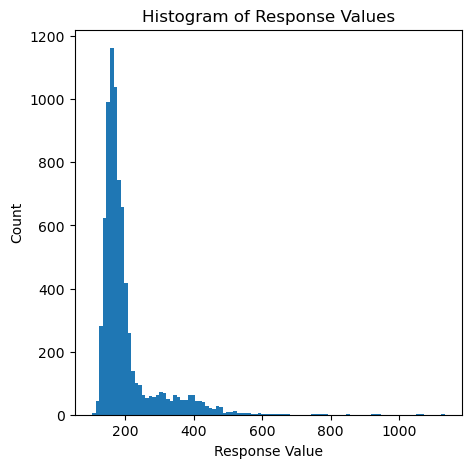

In [12]:
fig = plt.figure(figsize=[5, 5])
ax = fig.add_subplot(1, 1, 1)
ax.hist(Y_train, 100)
ax.set_xlabel('Response Value')
ax.set_ylabel('Count')
ax.set_title('Histogram of Response Values')    

## A Linear Model

Let's train a model. We'll start with a simple linear model. That means that what we're trying to optimise is this:

$\sum_{i=1}^{M}(y_i - \hat{y_i})^2 = \sum_{i=1}^{M} \left(y_i - \sum_{j=0}^p w_j \times x_{ij}\right)^2$

where
* $y_i$ is the actual value we're trying to predict (ground truth);
* $\hat{y_i}$ is what the model predicts;
* $i$ is a sample and $M$ is the number of samples that we have (i.e. how much data);
* $j$ is a dimension of the data, and $P$ is the number of dimensions that we have;
* $w_j$ is the learned weight for the th dimension (i.e. it's one of our regression coefficients); and
* $x_{ij}$ is the $i$th dimension of the $j$th input sample.

In [13]:
model = sm.OLS(Y_train, X_train)
trained_model = model.fit()
print(trained_model.summary())

                            OLS Regression Results                            
Dep. Variable:          x_1059__1060_   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.668
Method:                 Least Squares   F-statistic:                     504.2
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        02:32:45   Log-Likelihood:                -41127.
No. Observations:                7760   AIC:                         8.232e+04
Df Residuals:                    7728   BIC:                         8.254e+04
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            15.5238      4.717      3.291

Looking at our fitted model:
* most terms are significant, though we have some duds in there
* our $R^2$ is okay. We've captured a fair bit of what's going on, but the model is still far from perfect.

Becuase we can, let's have a quick look at the intersections with poor p-values:

In [14]:
intersection_details.where(intersection_details['LINK_DETAILS'].str.contains('1057->1056|1017->1007|1135->1231')).dropna()

,LINK_DETAILS,ORIGIN_DESC,ORIGIN_LONGITUDE,ORIGIN_LATITUDE,DEST_DESC,DEST_LONGITUDE,DEST_LATITUDE
33,1135->1231,CCTV1406 Pacific Motorway at Hawthorne Street,153.032469,-27.487992,South of Captain Cook Bridge (CS25),153.030813,-27.482910
50,1057->1056,Intersection Gympie and Hamilton Roads (M1116),153.030897,-27.385892,Intersection Gympie and Rode Roads (M1113),153.030954,-27.393409
108,1017->1007,At Boundary Road Interchange (M7084),152.991910,-27.211420,Bruce Highway near Anzac Ave Interchange,153.016018,-27.245606


One of our crap terms is from the Pacific Motorway, a long way from Gympie road, so that makes sense. The others' however are somewhat closer, including one on Gympie road. If you look carefully at the origin and destination latitude, you'll notice that these two links are both heading south, while our response is heading north. So really, the reasons why these are not that helpful does make a fair bit of sense.

Let's also now run through some qq-plots and look at the residuals.

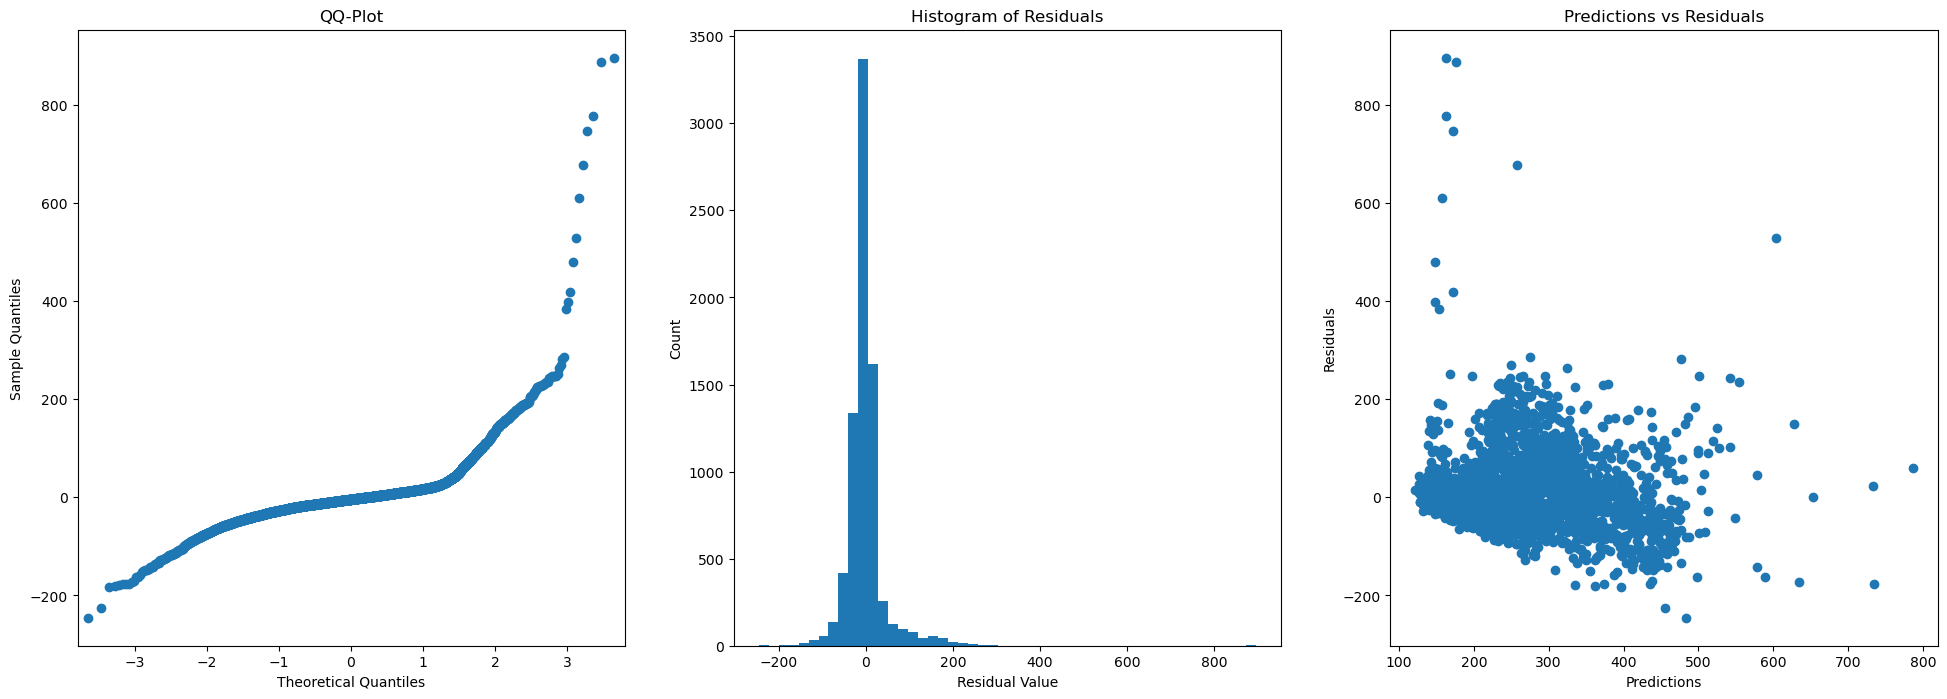

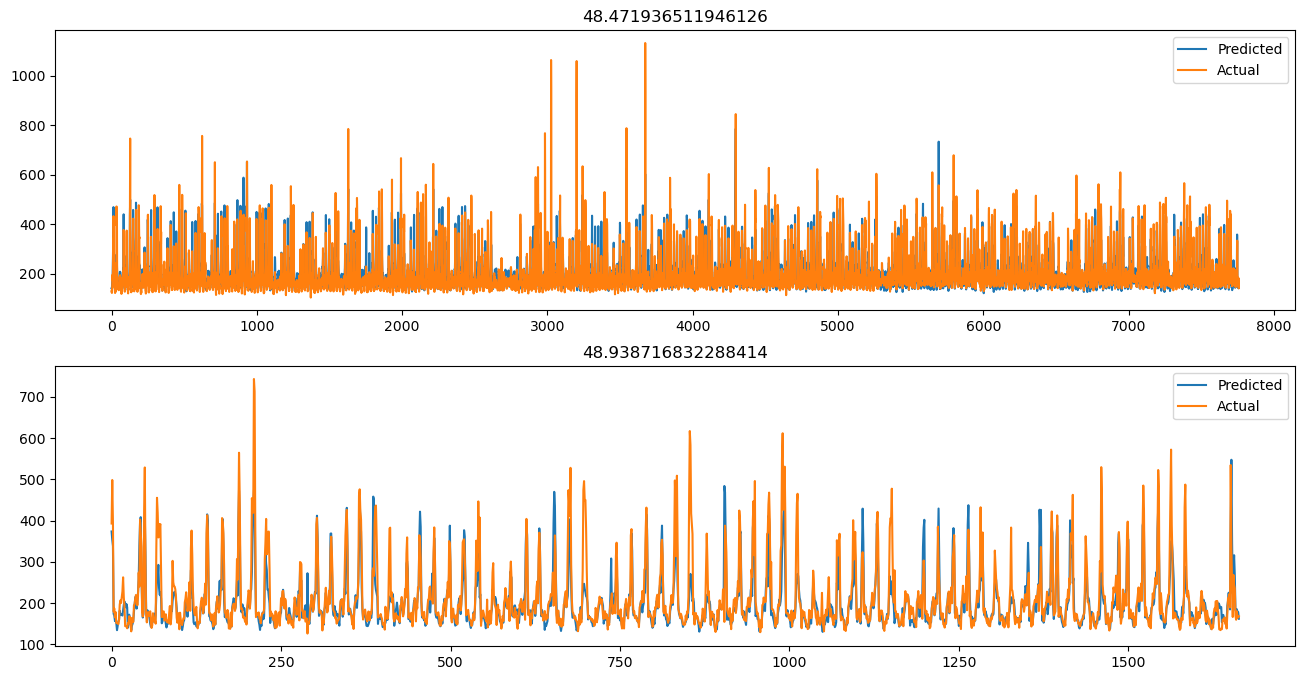

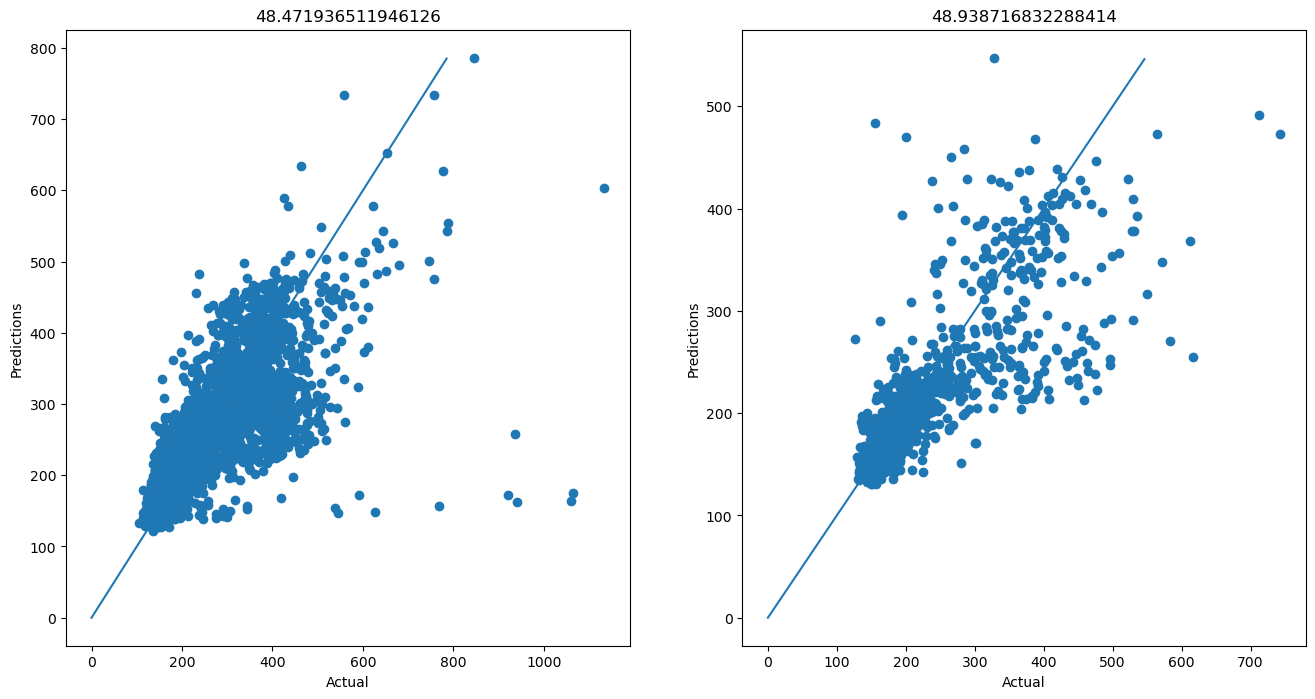

In [15]:
# All in one diagnostics function. This will:
# - plot various residual plots
# - optionally (if show_line == True) show line plots of predicted and GT values
# - optionally (if show_scatter == True) show scatter plots of predicted and GT values
# - Correct for standardisation, scaling Y-values back into the original range (or doing nothing if Y_mu == 0 and Y_sigma == 1)
#
def plot_diagnoistics(trained_model, resid, X_train, Y_train, X_test, Y_test, show_line = True, show_scatter = True, Y_mu = 0, Y_sigma = 1):

    # undo standardisation, multiply by sigma, add mu
    Y_train_pred = trained_model.predict(X_train)*Y_sigma + Y_mu
    Y_test_pred = trained_model.predict(X_test)*Y_sigma + Y_mu
    
    # undo standardisation for testing data
    Y_train_scaled = Y_train*Y_sigma + Y_mu
    Y_test_scaled = Y_test*Y_sigma + Y_mu

    fig = plt.figure(figsize=[24, 8])
    ax = fig.add_subplot(1, 3, 1)
    f = sm.qqplot(resid, ax=ax)
    ax.set_title('QQ-Plot')    
    
    ax = fig.add_subplot(1, 3, 2)
    ax.hist(resid, 50)
    ax.set_xlabel('Residual Value')
    ax.set_ylabel('Count')
    ax.set_title('Histogram of Residuals')    

    ax = fig.add_subplot(1, 3, 3)
    ax.scatter(Y_train_pred, resid)
    ax.set_xlabel('Predictions')
    ax.set_ylabel('Residuals')
    ax.set_title('Predictions vs Residuals')

    rmse_train = numpy.sqrt(numpy.mean((Y_train_pred - Y_train_scaled)**2))
    rmse_test = numpy.sqrt(numpy.mean((Y_test_pred - Y_test_scaled)**2))

    if show_line:
        fig = plt.figure(figsize=[16, 8])
        ax = fig.add_subplot(2, 1, 1)
        ax.plot(numpy.arange(len(Y_train_pred)), Y_train_pred, label='Predicted')
        ax.plot(numpy.arange(len(Y_train_pred)), Y_train_scaled, label='Actual')
        ax.set_title(rmse_train)
        ax.legend()

        ax = fig.add_subplot(2, 1, 2)
        ax.plot(numpy.arange(len(Y_test_pred)), Y_test_pred, label='Predicted')
        ax.plot(numpy.arange(len(Y_test_pred)), Y_test_scaled, label='Actual')
        ax.set_title(rmse_test)
        ax.legend()

    if show_scatter:
        fig = plt.figure(figsize=[16, 8])
        ax = fig.add_subplot(1, 2, 1)
        ax.scatter(Y_train_scaled, Y_train_pred)
        v = int(numpy.min([numpy.max(Y_train_scaled), numpy.max(Y_train_pred)]))
        ax.plot(numpy.arange(0, v))
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predictions')
        ax.set_title(rmse_train)

        ax = fig.add_subplot(1, 2, 2)
        ax.scatter(Y_test_scaled, Y_test_pred)
        v = int(numpy.min([numpy.max(Y_test_scaled), numpy.max(Y_test_pred)]))
        ax.plot(numpy.arange(0, v))
        ax.set_xlabel('Actual')
        ax.set_ylabel('Predictions')
        ax.set_title(rmse_test)

plot_diagnoistics(trained_model, trained_model.resid, X_train, Y_train, X_test, Y_test)

Further analysis suggests:
* Our model is not looking too good in terms of validity, the residuals are very much not normally distributed and we have this huge tail on one side. Remember how the distribution of our response was not Gaussian with a huge tail on the high side of the values? That's not helping us here.
* We don't appear to be overfitting, performance looks similar between both training and testing data, with the testing data actually better.
* On the whole, our model seems to have captured the major trends in the data with big peaks seeming to be in the right spot, but lots of smaller peaks are missed. Predictions and ground truth seem correlated too (bigger actual values lead to bigger predictions), but predictions are far from perfect
* Our ground truth has a clear minimum value, which leads to what look like straight lines on our scatter plots (predictions vs residuals, and both actual vs predictions)

### Adding Complexity

Given that we haven't overfit, we have scope to add complexity to the model. Let's do that. We'll create fourth order polynomial terms for our timing data, and add the categoricals back to those. Note that I am exluding my categoricals from this process. Some APIs (and MATLAB for example) will include categoricals when computing higher order terms.

In [16]:
poly_transform = PolynomialFeatures(4)
X_poly = poly_transform.fit_transform(data_to_use.iloc[:,1:-1])
X_poly = numpy.concatenate([X_poly, dummies], axis=1)
print(X_poly.shape)
X_train_poly = X_poly[0:training_samples, :]
X_val_poly = X_poly[training_samples:(training_samples + validation_samples), :]
X_test_poly = X_poly[(training_samples + validation_samples):, :]
print(X_train_poly.shape)
print(X_val_poly.shape)
print(X_test_poly.shape)

(11087, 518)
(7760, 518)
(1663, 518)
(1664, 518)


In [17]:
model_poly = sm.OLS(Y_train, X_train_poly)
model_poly = model_poly.fit()
print(model_poly.summary())

                            OLS Regression Results                            
Dep. Variable:          x_1059__1060_   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     45.14
Date:                Tue, 09 Jan 2024   Prob (F-statistic):               0.00
Time:                        02:32:50   Log-Likelihood:                -39861.
No. Observations:                7760   AIC:                         8.075e+04
Df Residuals:                    7247   BIC:                         8.432e+04
Df Model:                         512                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5368.7344   2740.195      1.959      0.0

Looking at our model:
* It's big. Some of our p-values look pretty poor, but the idea of tidying these up and removing poor terms is far from appealing.
* Our $R^2$ has gotten better, but not massivley so.

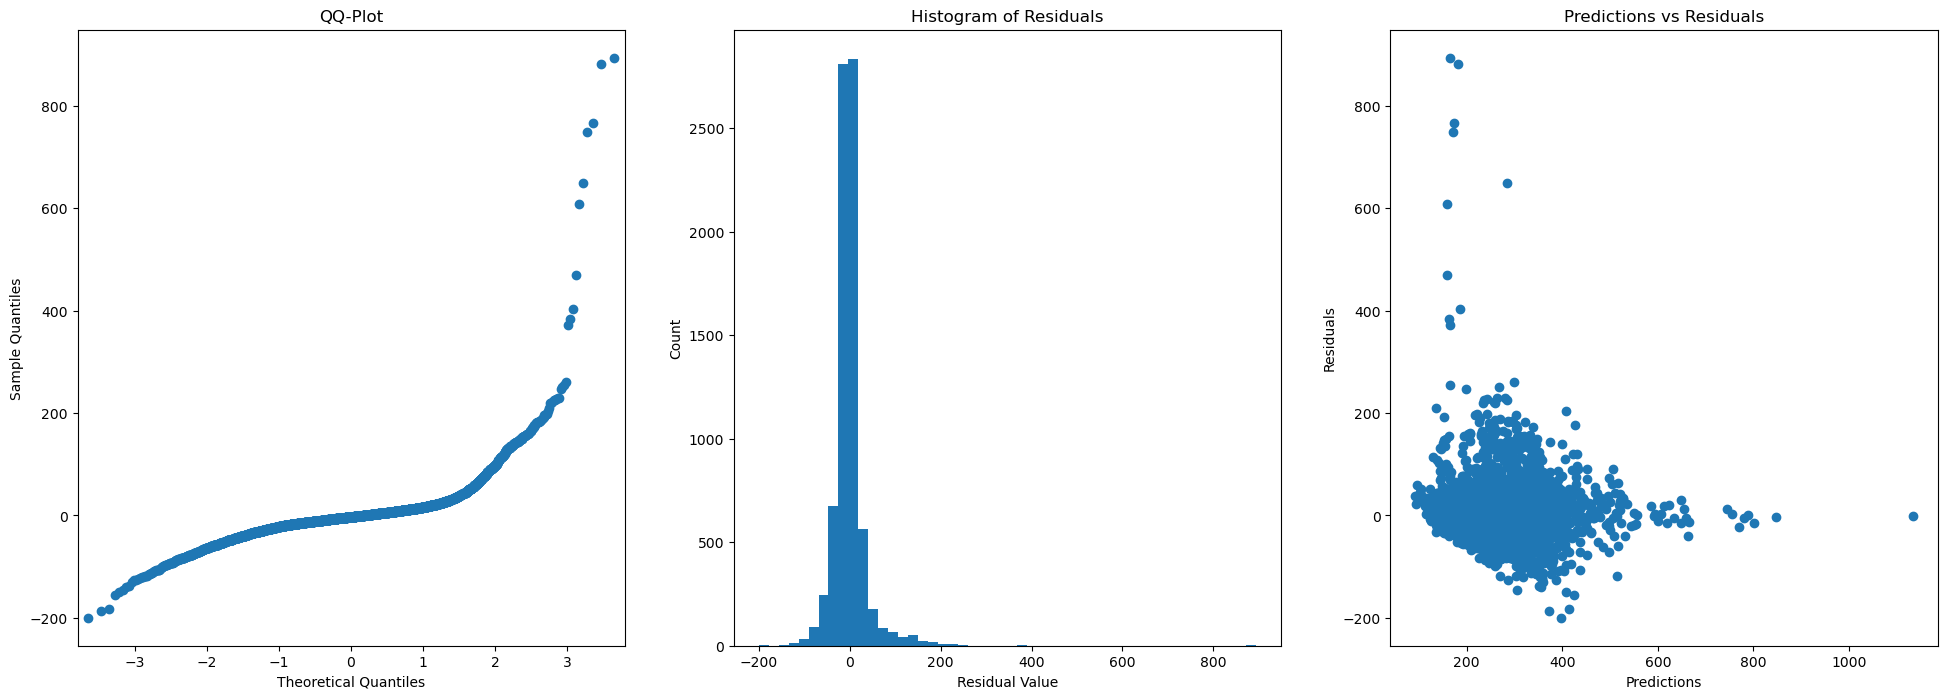

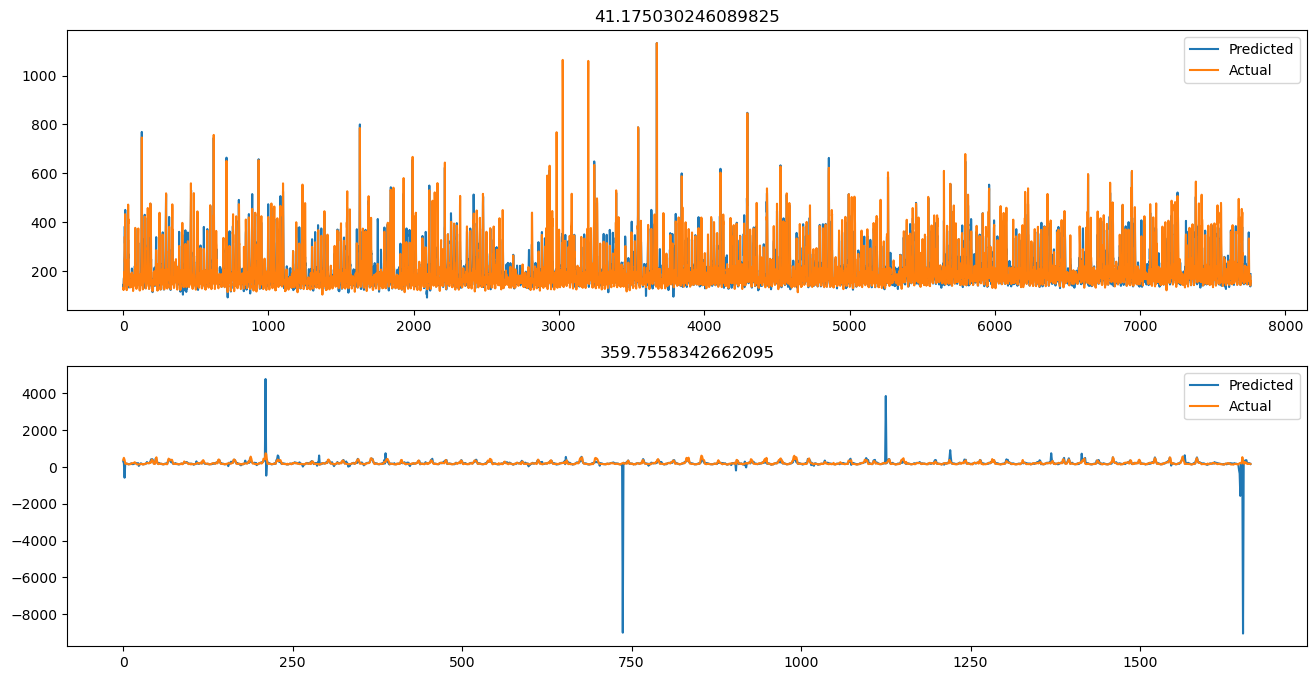

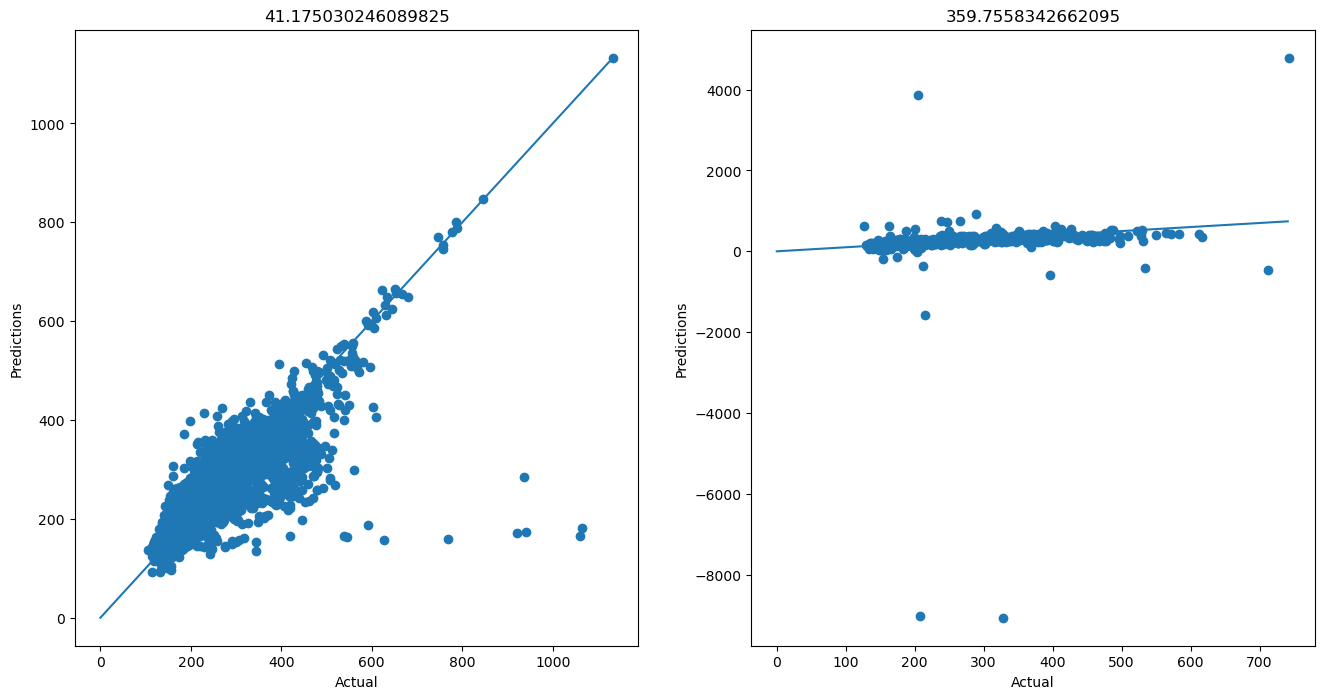

In [18]:
plot_diagnoistics(model_poly, model_poly.resid, X_train_poly, Y_train, X_test_poly, Y_test)

Further analysis shows:
* The model is still not showing a Gaussian distribution of residuals
* We have some severe prediction errors going on. We've gotten more accurate on the training data, and less accurate on the testing data, with a couple of massive errors.

At this point, we're overfitting, and we're starting to get some interesting errors in the testing data. Ideally at this point, we'd simplify our model, which means removing terms. However, doing this manually (i.e. going through and identifying poor terms, removing them, etc) is not really practical with a model of this size. Hence, we'll use regularisation.

Also from this point on I'm going to ditch the line plots and just use the scatter plots of actual vs predictions.

## Ridge (L2) Regularisation

Ridge regression, named for the former game show host [Glenn Ridge](https://www.youtube.com/watch?v=bpcIKCzmNDk) (I made that up, it actually isn't), has the following form:
$\sum_{i=1}^{M}(y_i - \hat{y_i})^2 = \sum_{i=1}^{M} \left(y_i - \sum_{j=0}^p w_j \times x_{ij}\right)^2 + \lambda \sum_{j=0}^p w_j^2$

This looks a fair bit like OLS regression, but with $\lambda \sum_{j=0}^p w_j^2$ tacked onto the end. This is the "L2 penalty term", and while that sounds odd, it just means the sum of squared values of the terms (i.e. all of our learned coefficients).

Note that there is a scale out the front of all this, $\lambda$. This determines how strong the regularisation is. If $\lambda = 0$, then this whole thing reverts to regular least squares regression. As it gets bigger and bigger, the regularisation term will dominante and make the weights small (which is what this term is trying to do), as this term becomes more important than actually fitting the data.

The overall impact of the penalty term is to promote small weights, based on the intuition that a small change in the input should lead to a small change in the output.

Let's start with a Ridge model with an arbitrary value of $\lambda$.

#### A Note About the StatsModels Regularised Regression Implementation

StatsModels does not have separate functions for Ridge and LASSO. It has one function `fit_regularized` that does both (and something else called *Elastic Net*). `fit_regularized` has an argument, `L1_wt`, which is set to between 0 and 1 and indicates the weight placed on the L1 regularisation term (i.e. the LASSO term). Whatever weight is left is placed on the L2 (Ridge) term. If we set `L1_wt=0`, it means that there is no weight on the L1 term, and so we have pure Ridge regression.

In this example we're going to either set `L1_wt=0` when we're doing Ridge regression, or `L1_wt=1` when we're doing LASSO. If we picked a value somewhere in the middle, we'd have both Ridge and LASSO regularisation terms active and be doing *Elastic Net Regression*. This is outside the scope of CAB420.

In [19]:
trained_model_poly_ridge = sm.OLS(Y_train, X_train_poly).fit_regularized(alpha=1, L1_wt=0.0)

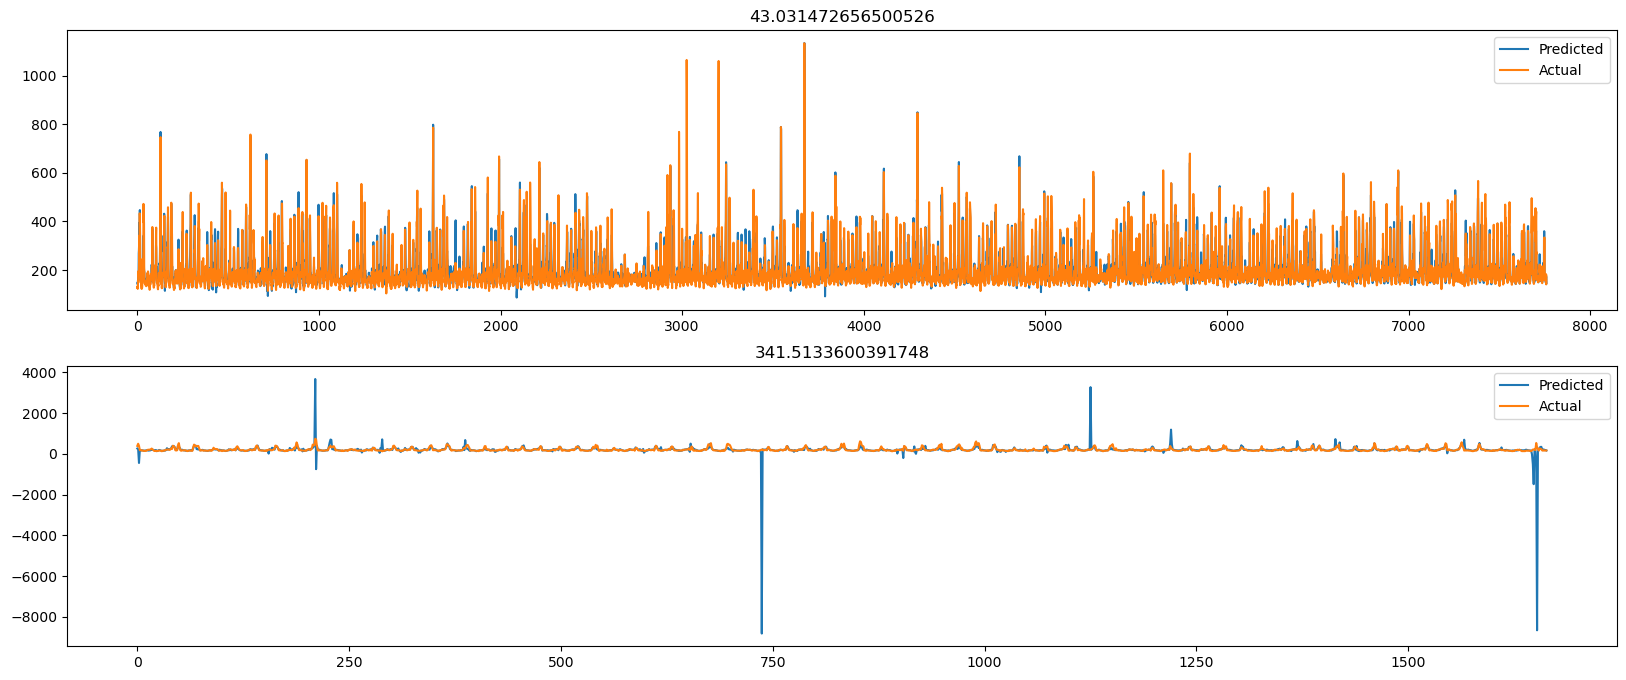

In [20]:
Y_train_poly_pred = trained_model_poly_ridge.predict(X_train_poly)
Y_test_poly_pred = trained_model_poly_ridge.predict(X_test_poly)
rmse_train = numpy.sqrt(numpy.mean((Y_train_poly_pred - Y_train)**2))
rmse_test = numpy.sqrt(numpy.mean((Y_test_poly_pred - Y_test)**2))

fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(2, 1, 1)
ax.plot(numpy.arange(len(Y_train_poly_pred)), Y_train_poly_pred, label='Predicted')
ax.plot(numpy.arange(len(Y_train_poly_pred)), Y_train, label='Actual')
ax.set_title(rmse_train)
ax.legend()
ax = fig.add_subplot(2, 1, 2)
ax.plot(numpy.arange(len(Y_test_poly_pred)), Y_test_poly_pred, label='Predicted')
ax.plot(numpy.arange(len(Y_test_poly_pred)), Y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend()

It's fair to say our model is not great. Why? Quite simply we chose a poor value of $\lambda$.

What we need to do is consider a range of values, and find the one that's best. Let's do that now.

There are a couple of ways that we can pull out our values of $\lambda$. The easy one is just to create a linearly spaced list, which we can do with something like `numpy.arange`. This is fine, but also means that to find an optimal value of $\lambda$ make take either a lot of values, or a lot of iterations.

Another approach is to use a set of values on a log scale, such that we have more values at the low end of our list. This can help us search a bit more efficiently, and is what I'm going to do. Here, we'll specify a minimum and maximum exponent, and then, end up with a list of values in the interval $[10^{min}...10^{max}]$. Let's say we use -2 and 2 as our values of min and max, so we'd be searching between 0.01 and 100. This is useful as we'll typically see more dramatic changes in performance when $\lambda$ is smaller, but as we still don't actually know what a good value of $\lambda$ is when we start, being able to search a large range, even if it's only very coarsely, if helpful. To illustrate this, let's look at what we'd get for a linear list between $[0..100]$, and a log-scale list of almost the same range (the minimum is not quite 0).

In [21]:
print(numpy.arange(0, 100, 10))
print(numpy.logspace(-2, 2, 10))

[ 0 10 20 30 40 50 60 70 80 90]
[1.00000000e-02 2.78255940e-02 7.74263683e-02 2.15443469e-01
 5.99484250e-01 1.66810054e+00 4.64158883e+00 1.29154967e+01
 3.59381366e+01 1.00000000e+02]


We can see our second list is not uniformly spaced - we've got more small values, but we're still going up to the same maximum as our other list. The one catch with using a log scale is that we can't get a value of 0 in our list of possible values to consider - so we'll probably want to capture the performance at $\lambda=0$ (i.e. a vanilla linear model with no regularisation) and compare that to our smallest value of $\lambda$ to ensure that regularisation is infact helping.

I'm going to proceed with the log-scale version, but I've got a linear version of what we'd need commented out below too incase you're not comfortable with the log scale values.

In [22]:
# linear scale, values from [0..1000] in steps of 50
# lambdas = numpy.arange(0, 10, 0.5)
# log scale, values from [0.00000001 to 10], 20 values total
lambdas = numpy.logspace(-8, 1, 20)
rmse_train = []
rmse_validation = []
for l in lambdas:
    trained_model_poly_ridge = sm.OLS(Y_train, X_train_poly).fit_regularized(alpha=l, L1_wt=0.0)
    rmse_train.append(numpy.sqrt(numpy.mean((trained_model_poly_ridge.predict(X_train_poly) - Y_train)**2)))    
    rmse_validation.append(numpy.sqrt(numpy.mean((trained_model_poly_ridge.predict(X_val_poly) - Y_val)**2)))

Looking at the results, we see some variation in accuracy with $\lambda$. We see the characteristic shape that you'll come to know with regularised regression. Basically, our validation RMSE starts big, as we increase $\lambda$ it improves up to some point, and then as we increase lambda beyond this point it gets worse again (we also get a little wave in this plot, which is a bit odd and you won't always see, and I think is a quirk of this data and the optimiser used by statsmodels). The value of $\lambda$ that gives us the minimum on the validation RMSE curve is the one that we want.

There are a couple of other things that are also important, but are not really visible on this plot:
* As $\lambda$ gets bigger and bigger, the validation RMSE curve flattens out, and will eventually converge to some constant. This is the point at which the model becomes a constant (all terms go to 0). We're not showing big enough values of $\lambda$ to see this.
* Our training RMSE is always increasing, until it too converges when the model becomes a constant.

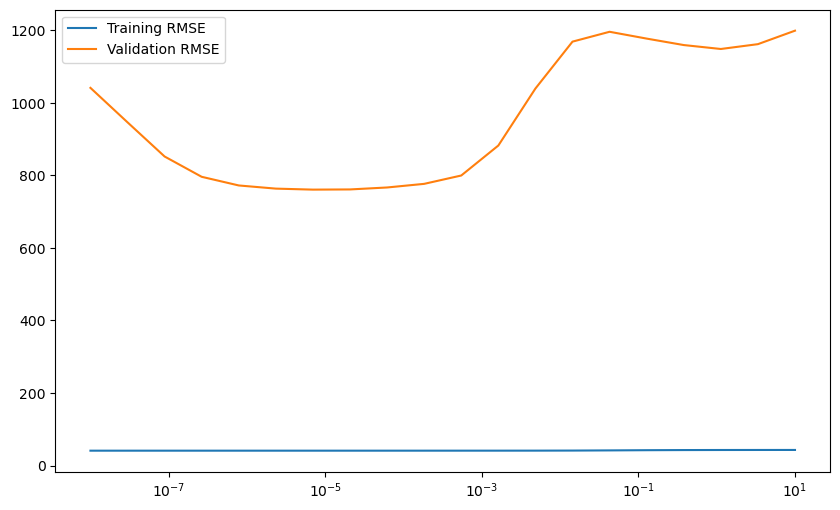

In [23]:
fig = plt.figure(figsize=[10, 6])
ax = fig.add_subplot(1, 1, 1)
ax.plot(lambdas, rmse_train, label='Training RMSE')
ax.plot(lambdas, rmse_validation, label='Validation RMSE')
# set x-axis to log scale
ax.set_xscale('log')
ax.legend();

First up, I mentioned before with the log-space approach that we don't get a $\lambda=0$ here, so we need to check if regularisation actually is helping. Thankfully, we can clearly see that as we increase $\lambda$, our validation RMSE is going down (for a while at least, until we reach our minimum). So we know that regularisation is helping. We're also starting at a point very near 0.

The other thing to consider here is that in all cases, our validation RMSE is way bigger than the training RMSE, so we've not really solved our overfitting issue yet. There's actually something else we can do to the data to help with this.

Let's have a look at the distribution of our data. We'll run a boxplot over the polynomial terms. I don't care about the categorical terms here as they are either 1 or 0, so aren't very interesting from a statistical point of view.

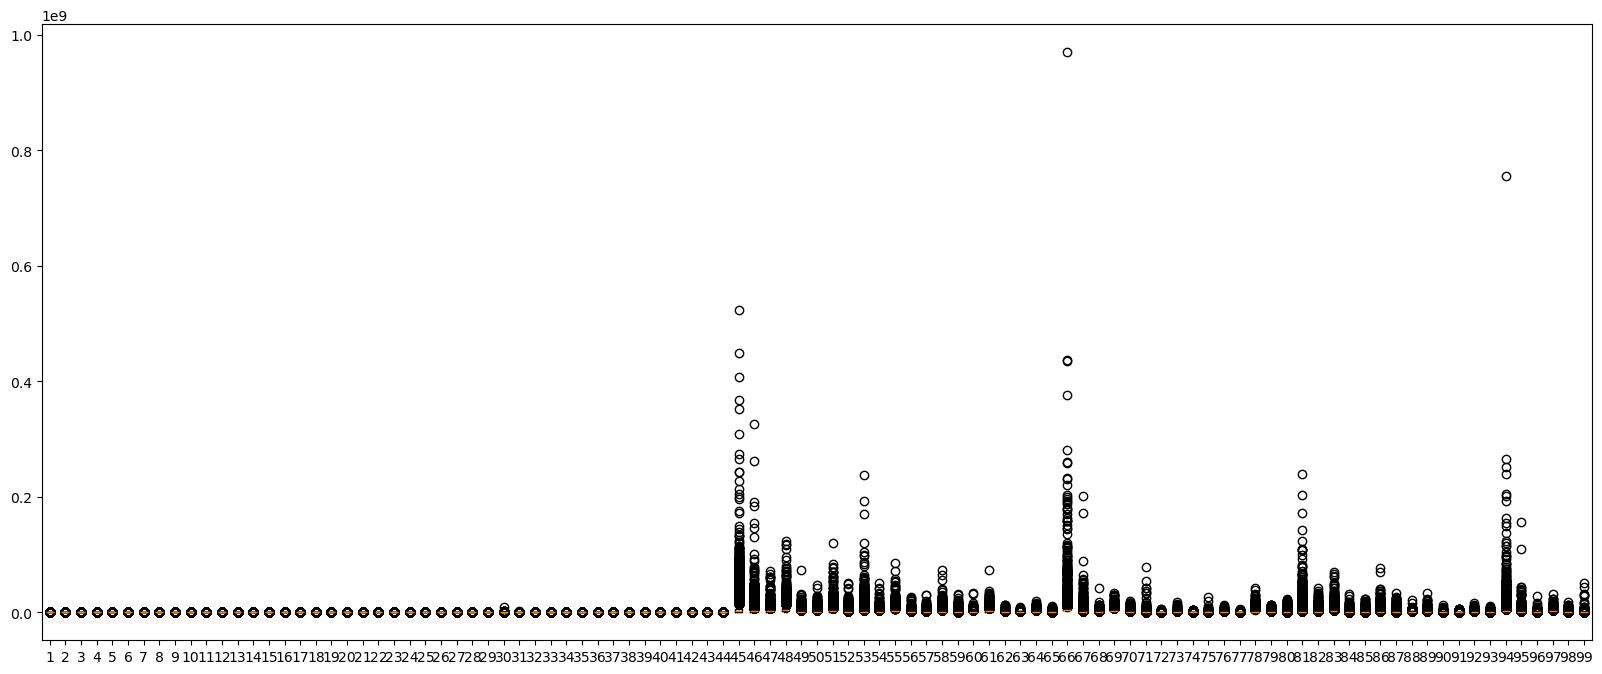

In [24]:
X_poly = poly_transform.fit_transform(data_to_use.iloc[:,1:-1])
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_poly[:,1:100]);

Looking at the above, we can clearly see that we have some variables with a much greater range than others. Note that I'm just looking at the first 100 here, it get's even more extreme in some of the later variables.

This variation in range of values has a direct impact on the model weights that we learn. Consider:
* A variable with a very large range, this will need only a small weight to have a large impact on the output, as there will naturally be high variation in high variation in the variable
* A variable with a very small range, this will need a large wieght to have a large impact on the output, as there will naturally be low variation in the variable

However, our regularisation has no idea about what the range of a variable is, and thus what sort of weight might be "reasonable". It will try to minimise all weights equally (while maximising accuracy), which means that variables with a large range can distort results.

### Standardisation

The solution to this issue is standardisation. This does the following:

$\hat{x_i} = \frac{x_i - \mu}{\sigma}$

where:
* $\hat{x_i}$ is a standardised sample
* $x_i$ is the original data point
* $\mu$ is the mean of the data
* $sigma$ is the standard deviation of the data

After standardisation, out data will have a mean of 0, and a standard deviation of 1. By applying this to each dimension, we end up with all variables having a mean of 0 and standard deviation of 1, and thus our regularised regression can better consider all the terms equally.

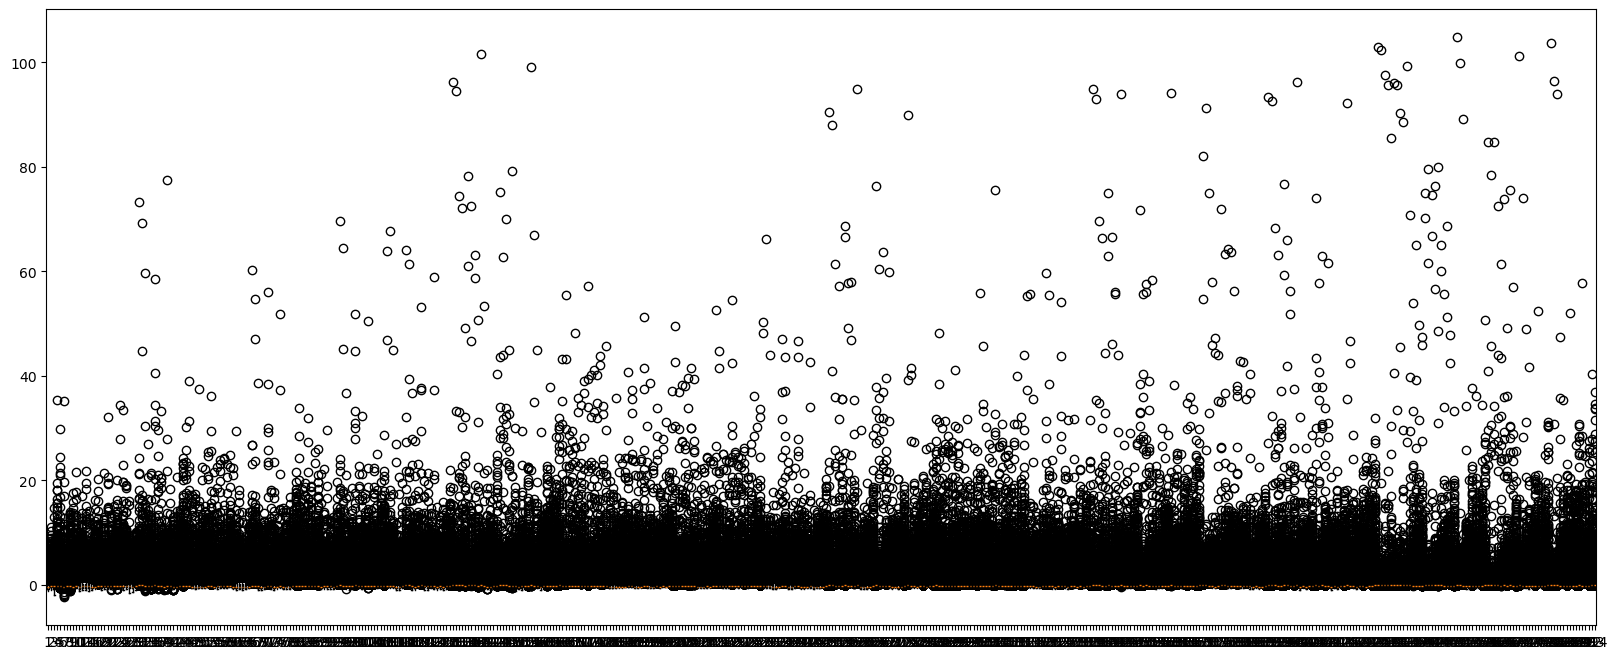

In [25]:
mu = numpy.mean(X_poly[:,1:],0)
sigma = numpy.std(X_poly[:,1:],0)
X_poly = (X_poly[:,1:] - mu) / sigma
fig = plt.figure(figsize=[20, 8])
ax = fig.add_subplot(1, 1, 1)
ax.boxplot(X_poly);

The plot of our standardised data looks much more uniform now. Note that our data is still a bit skewed in that we only have outliers on one side of the mean, which is a result of there being a lower bound on travel times (i.e. 0, as cars do not go faster than the speed of light), yet no upper bound.

We'll now recompute out training and testing sets, and we'll also standardise our output variable for consistency. We save the mean and std.dev when we do this so we can get back to the original data if we wish.

#### A Note on Standardisation Best Practices

Standardisation can be considered as a pre-processing step. We want to ensure that for all data, we apply the same pre-processing. What this means is that we use the same values for the mean and standard deviation to standardise the data. As such, what we'll do is:
* Split the data, into train, validation and testing sets
* Comptue the mean and standard deviation on the training set
* Use this mean and standard deviation to standardise all data

Sadly, the code for this looks more complex than it is because we're keeping the categorical variables out of our standardisation. We're going to split all the data except the categoricals, get our means and std devs, and then when we standardise we'll also concatenate the relevant categorical samples back in again.

In [26]:
X_poly = poly_transform.fit_transform(data_to_use.iloc[:,1:-1])
# split data
X_train_poly = X_poly[0:training_samples, :]
X_val_poly = X_poly[training_samples:(training_samples + validation_samples), :]
X_test_poly = X_poly[(training_samples + validation_samples):, :]

# mean and std dev for the training set
mu = numpy.mean(X_poly[:,1:],0)
sigma = numpy.std(X_poly[:,1:],0)

# standardise all sets using the same mean and std dev
# for clarity, we can break this down a bit into:
#  - concatenating the polynomial variables and the categoricals
X_train_poly = numpy.concatenate(
#  - standardising the polynomial variables
    [(X_train_poly[:,1:] - mu) / sigma, 
#  - pulling out the appropriate set of samples for the categoricals
     dummies.iloc[0:training_samples, :].to_numpy()], 
    axis=1)
X_val_poly = numpy.concatenate([(X_val_poly[:,1:] - mu) / sigma, dummies.iloc[training_samples:(training_samples + validation_samples), :]], axis=1)
X_test_poly = numpy.concatenate([(X_test_poly[:,1:] - mu) / sigma, dummies.iloc[(training_samples + validation_samples):, :]], axis=1)

# rinse and repeat for the Y data
# split it
Y_train = Y[0:training_samples]
Y_val = Y[training_samples:(training_samples + validation_samples)]
Y_test = Y[(training_samples + validation_samples):]

# get mean and std dev
Y_mu = numpy.mean(Y_train)
Y_sigma = numpy.std(Y_train)

# use mean and std dev to standardise
Y_train = (Y_train - Y_mu) / Y_sigma
Y_val = (Y_val - Y_mu) / Y_sigma
Y_test = (Y_test - Y_mu) / Y_sigma

### Standardisation and Constant Terms

One note that obvious thing in the above code that's worth noting is what's going on with the constant term. After the call to `poly_transform.fit_transform`, the firt column of result is a column of 1's. In later steps, such as here:
```
mu = numpy.mean(X_poly[:,1:],0)
```
and here
```
X_train_poly = numpy.concatenate(
    [(X_train_poly[:,1:] - mu) / sigma, 
     dummies.iloc[0:training_samples, :].to_numpy()], 
    axis=1)
```
The constant terms is being removed. 

This is because when we standardise the data, the constant term is removed from the model. Essentially, our regression formula goes from

$\hat{y} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$

to 

$\hat{y} = \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n$,

because the process of standardisation sets $\beta_0 = 0$.

### (Glenn) Ridge with Standardised Data

Let's repeat the ridge regression with standardised data.

Let's also take a minute to break down exactly what we're doing here:
* We're going to select a range of values for $\lambda$ to try
* For each value of $\lambda$, we'll fit a model, and then compute the RMSE on the training and validation data
* We're then plotting these RMSE's. Ultimatley, we want the model that achieves the lowest RMSE on the **validation data**

Why the validation data you ask? Because the accuracy on the training data will only go down as $\lambda$ increases. Remember the equation we're trying to solve here:

$\sum_{i=1}^{M}(y_i - \hat{y_i})^2 = \sum_{i=1}^{M} \left(y_i - \sum_{j=0}^p w_j \times x_{ij}\right)^2 + \lambda \sum_{j=0}^p w_j^2$

As $\lambda$ increases, less emphasis is given to the first term which is concerned with fitting the training data. As such, we will get the best fit to the training data when $\lambda = 0$.

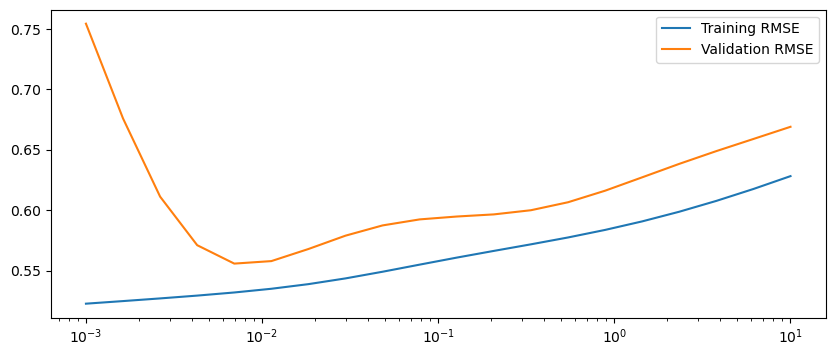

In [27]:
# linear option
#lambdas = numpy.arange(0, 10, 0.5)
lambdas = numpy.logspace(-3, 1, 20)
rmse_train = []
rmse_validation = []
coeffs = []
for l in lambdas:
    trained_model_poly_ridge = sm.OLS(Y_train, X_train_poly).fit_regularized(alpha=l, L1_wt=0.0)        
    coeffs.append(trained_model_poly_ridge.params)
    rmse_train.append(numpy.sqrt(numpy.mean((trained_model_poly_ridge.predict(X_train_poly) - Y_train)**2)))
    rmse_validation.append(numpy.sqrt(numpy.mean((trained_model_poly_ridge.predict(X_val_poly) - Y_val)**2)))
    
def plot_rmses(lambdas, rmse_train, rmse_validation, log_scale = True):
    fig = plt.figure(figsize=[10, 4])
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(lambdas, rmse_train, label='Training RMSE')
    ax.plot(lambdas, rmse_validation, label='Validation RMSE')
    if log_scale:
        ax.set_xscale('log')
    ax.legend()

# if I was using using a linear scale, call with 
# plot_rmses(lambdas, rmse_train, rmse_validation, log_scale = False)
plot_rmses(lambdas, rmse_train, rmse_validation)

We now see a much more noticeable difference as $\lambda$ changes. Again, we see an initial drop from our smallest value of $\lambda$, so we can be confident that the regularisation is helping. Again, there's a little wave in the validation RMSE, but we find a good first minimum which is our lowest - we expect that once we find our best value of $\lambda$ the validation RMSE will go up, so this is fine and above the little second valley is likely a quirk of the optimiser being used, and it not completely converging, but rather stopping before the true solution is reached.

We can also clearly see how the training RMSE is always increasing with $\lambda$. This is expected, and is why we need to select $\lambda$ from the validation set.

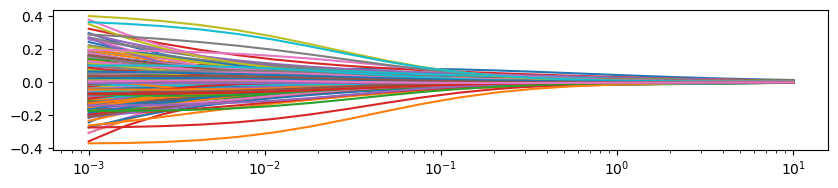

In [28]:
def plot_coeff(lambdas, coeffs, log_scale = True):
    fig = plt.figure(figsize=[10, 4])
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(lambdas, coeffs);
    if log_scale:
        ax.set_xscale('log')

# if I was using using a linear scale, call with 
# plot_coeff(lambdas, coeffs, log_scale = False)
plot_coeff(lambdas, coeffs)

The plot show how the coefficients (model parameters) vary as $\lambda$ changes. What we see is that as $\lambda$ increases, values on the whole get small (though some may still increase, at least for a while).

Critically, we see that although values get small, none go to zero. This means that terms get supressed, but not eliminated.

From this we can easily pick out the best value of $\lambda$ and train a model using that, and we can evaluate this model and get a sense for how well it works.

Note that in this evaluation, we convert the test data back from the standardised range into the original range to make it easy to compare this model with our earlier linear models. We can convert the data back simply by multiplying by the standard deviation, and adding the mean (i.e. the inverse of what we did to standardise it).

0.0069519279617756054


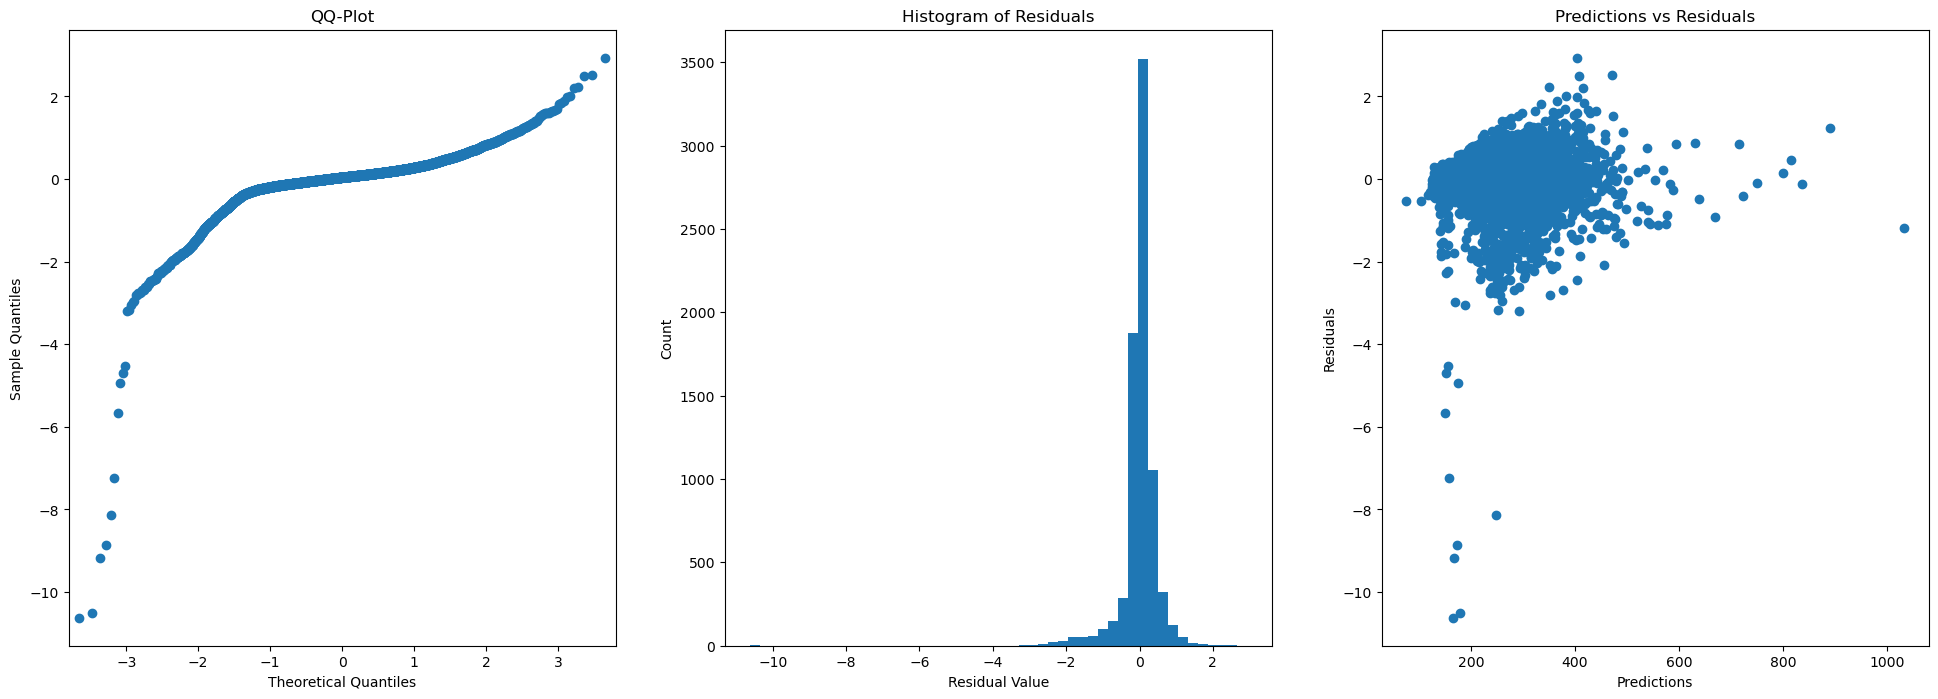

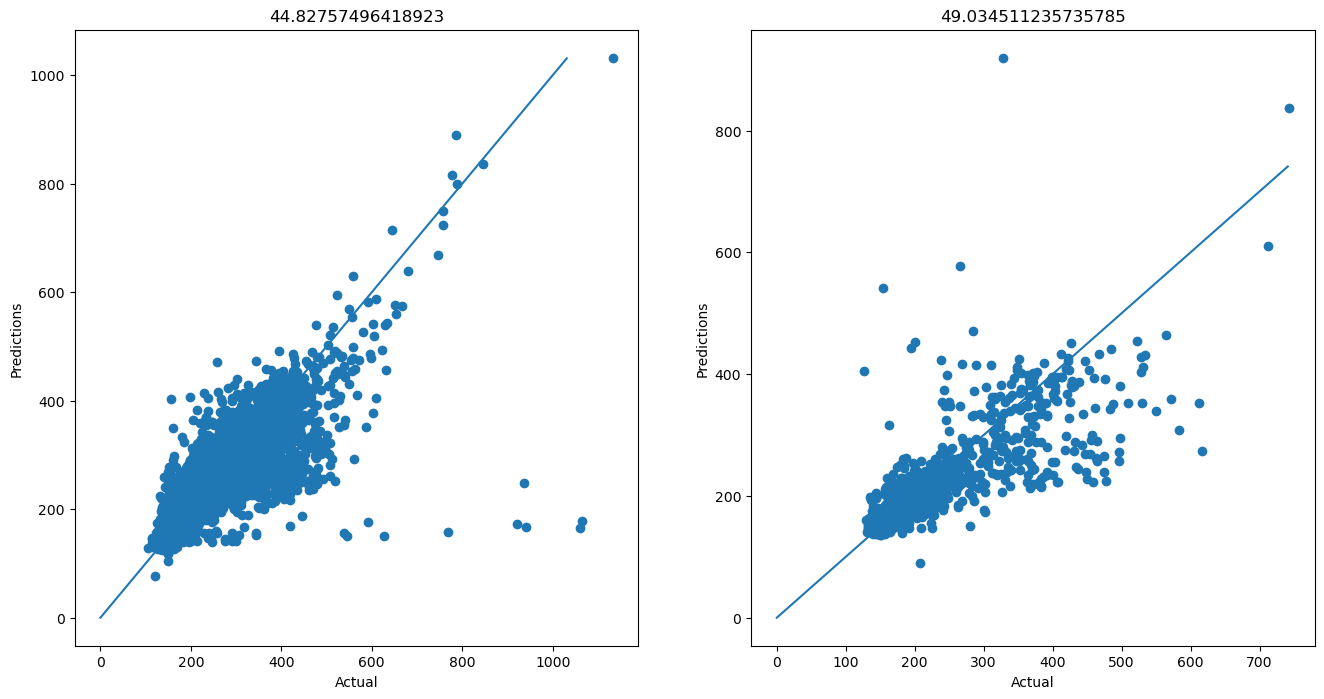

In [29]:
best_lambda = lambdas[numpy.argmin(rmse_validation)]
print(best_lambda)
trained_model_poly_ridge = sm.OLS(Y_train, X_train_poly).fit_regularized(alpha=best_lambda, L1_wt=0.0)

# plot diagnostics, passing in standardisation paramaters here so I can undo that for RMSE computation, etc
plot_diagnoistics(trained_model_poly_ridge, trained_model_poly_ridge.predict(X_train_poly) - Y_train, 
                  X_train_poly, Y_train, X_test_poly, Y_test, show_line = False, Y_sigma = Y_sigma, Y_mu = Y_mu)

Comparing this to our linear method, it works much better - though still not quite as well as the simpler model that we started with. 

Note that our value of $\lambda$ is not totally optimal, we've used only a few values across the range that we're considering. We could search again around our initial estimate to get a better value, but it probably won't make a massive difference.

## (Ted) Lasso and L1 Regularisation

Lasso regression modifies our standard least squares linear regression by adding an L1 penalty term, and this makes our objective look like this:

$\sum_{i=1}^{M}(y_i - \hat{y_i})^2 = \sum_{i=1}^{M} \left(y_i - \sum_{j=0}^p w_j \times x_{ij}\right)^2 + \lambda \sum_{j=0}^p |w_j|$

The "L1 penalty term" is a lot like our L2 penalty term, but it is the sum of absolute values of the terms (i.e. all of our learned coefficients), rather than sum of squares, i.e.:
$\lambda \sum_{j=0}^p |w_j|$

Note that once again, there is a scale out the front of all this, $\lambda$. This plays the same role as in ridge regression, and again if $\lambda = 0$, then this whole thing reverts to regular least squares regression. Again, the presence of this variable means that we need to work out what a good value of $\lambda$ is as well.

To do this, let's repeat what we did in the second half of the ridge regression investigation, i.e. using standardised data and looping over a range of $\lambda$'s.

#### How similar is this code to the ridge example??

Very. It's almost identical.

Remember, statsmodels has one regularised regression function, `fit_regularized`, and we just change `L1_wt` to indicate what type of regularisation we're applying. Now, we're into LASSO regularisation, so we set `L1_wt=1`.

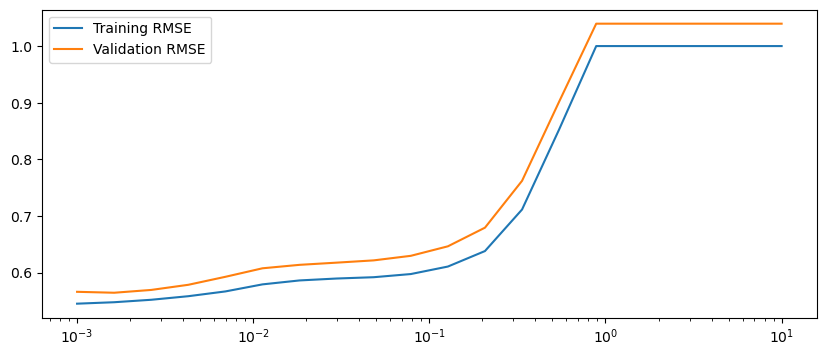

In [30]:
#lambdas = numpy.arange(0.0, 0.5, 0.025)
lambdas = numpy.logspace(-3, 1, 20)
rmse_train = []
rmse_validation = []
coeffs = []
for l in lambdas:
    trained_model_poly_lasso = sm.OLS(Y_train, X_train_poly).fit_regularized(alpha=l, L1_wt=1.0)
    coeffs.append(trained_model_poly_lasso.params)
    rmse_train.append(numpy.sqrt(numpy.mean((trained_model_poly_lasso.predict(X_train_poly) - Y_train)**2)))
    rmse_validation.append(numpy.sqrt(numpy.mean((trained_model_poly_lasso.predict(X_val_poly) - Y_val)**2)))
    
plot_rmses(lambdas, rmse_train, rmse_validation)

We see a similar trend here to what we saw above, though the initial drop in validation accuracy is way more subtle (if we considered really, really small values we would see a more pronounced initial drop - though generating such a plot is extremely slow which is why I've not done it). Considering the validation accuracy, we drop a bit until we reach some minimum, and then start to get worse again - with a little wobble along the way (once again likely due to the the optimiser used). Eventually, things will stop changing and we'll get to a constant model. We see with the flat line right at the end.

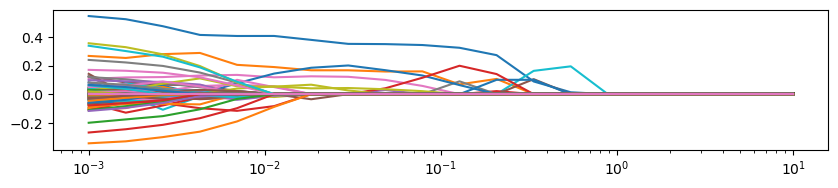

In [31]:
plot_coeff(lambdas, coeffs)

Plotting the trace of the coefficients, we see a much more interesting plot than we saw for ridge. The really big thing to note is that weights can go to 0, and by the end of the plot ($\lambda = 0.5$), all the weights are 0, i.e. we now have a constant model. Lasso will allow us to outright eliminate variables, rather than just supress them the way that ridge does.

Once again, we can select our best value of $\lambda$ and evaluate our model. Again, this value is likely not the most optimal $\lambda$ possible, but even if we tweak this further we won't see a huge change in performance.

In [32]:
best_lambda = lambdas[numpy.argmin(rmse_validation)]
print(best_lambda)

0.0016237767391887208


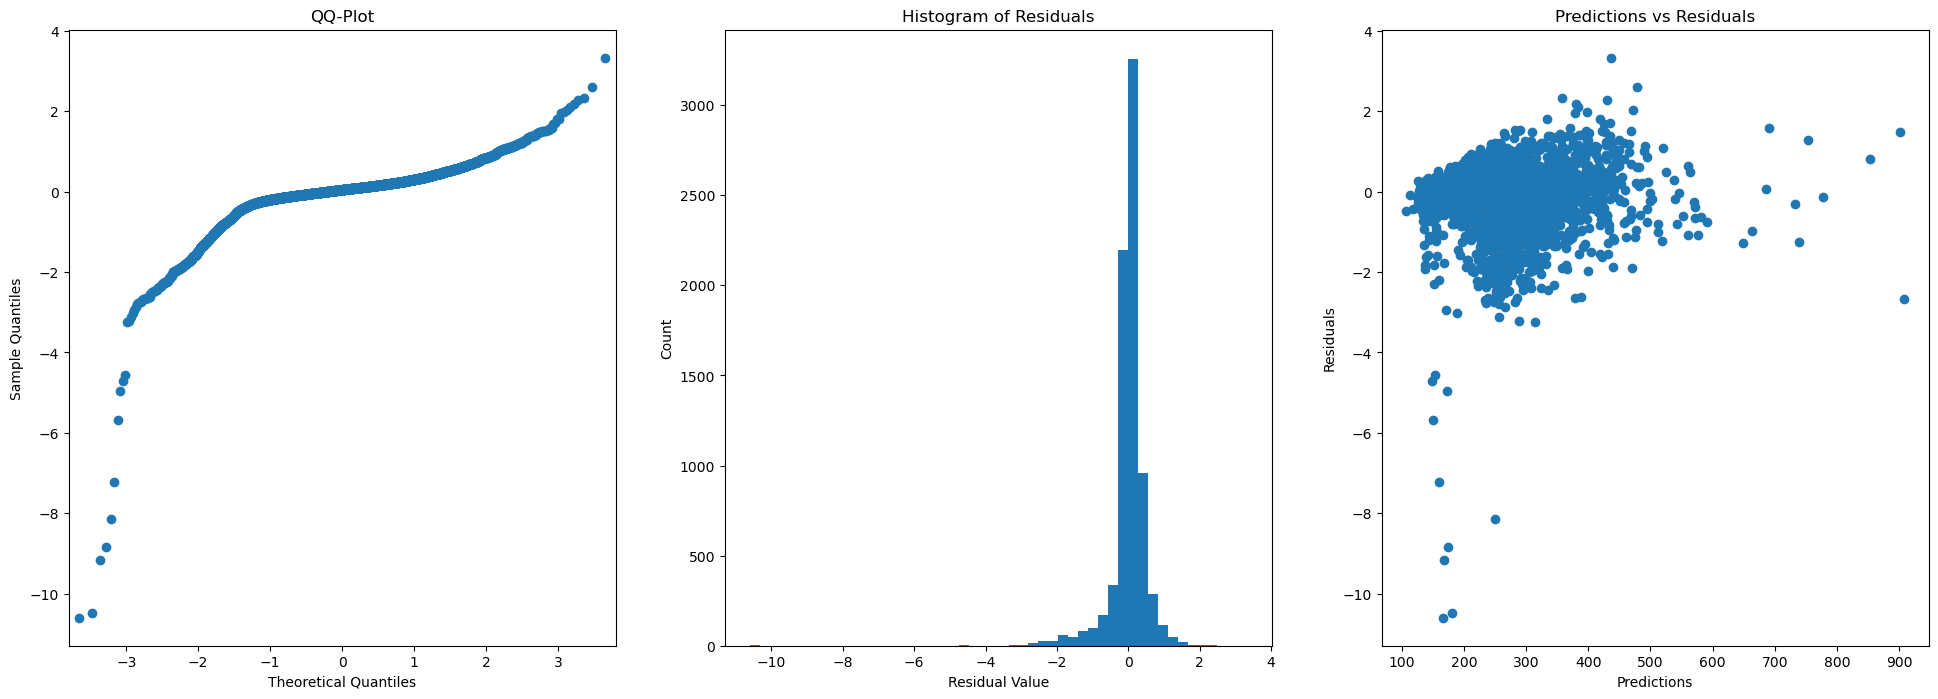

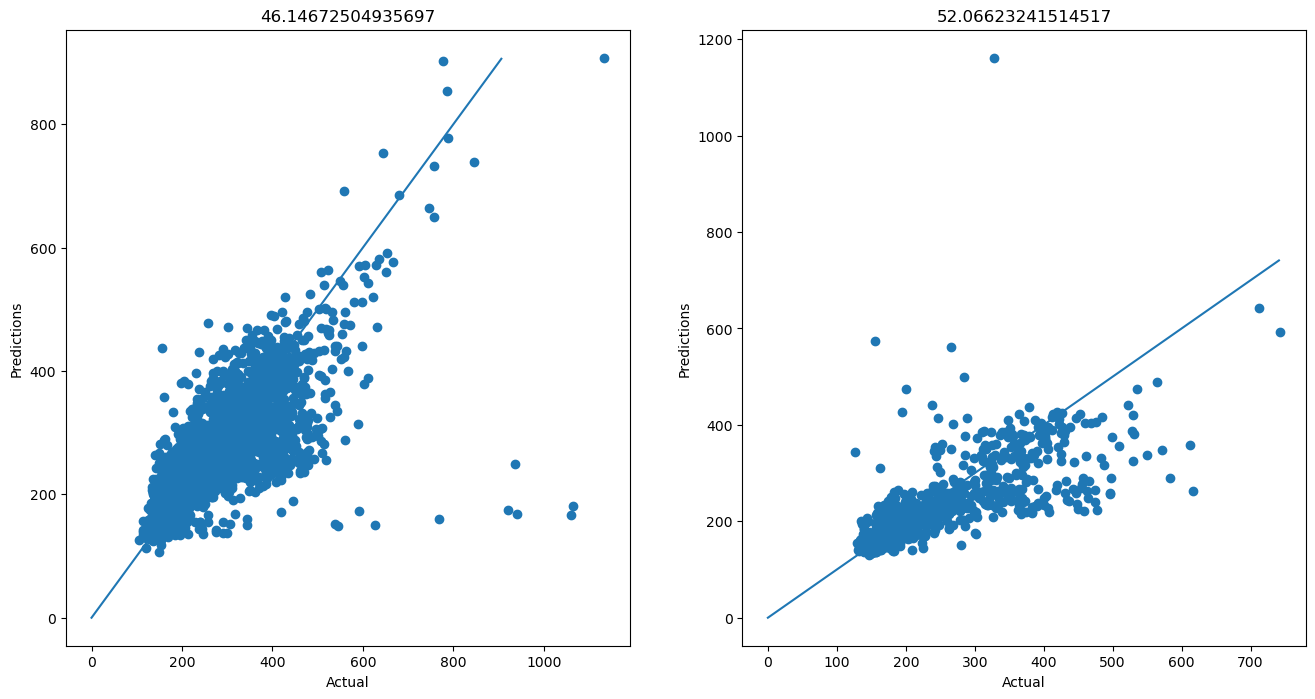

In [33]:
trained_model_poly_lasso = sm.OLS(Y_train, X_train_poly).fit_regularized(alpha=best_lambda, L1_wt=1.0)

plot_diagnoistics(trained_model_poly_lasso, trained_model_poly_lasso.predict(X_train_poly) - Y_train, 
                  X_train_poly, Y_train, X_test_poly, Y_test, show_line = False, Y_sigma = Y_sigma, Y_mu = Y_mu)

Having a look at how many terms we have left, we can see that our best model has only kept a bit over 100 terms out of ~500.

In [34]:
sum(trained_model_poly_lasso.params != 0)

93

## Comparing Models

Let's quickly compare our models - the linear model using the crazy data, and then the ridge and lasso versions. We are repeating some plots from above here, but it's easier than the endless scrolling that's otherwise needed.

Linear R**2 = 0.7612707046087573


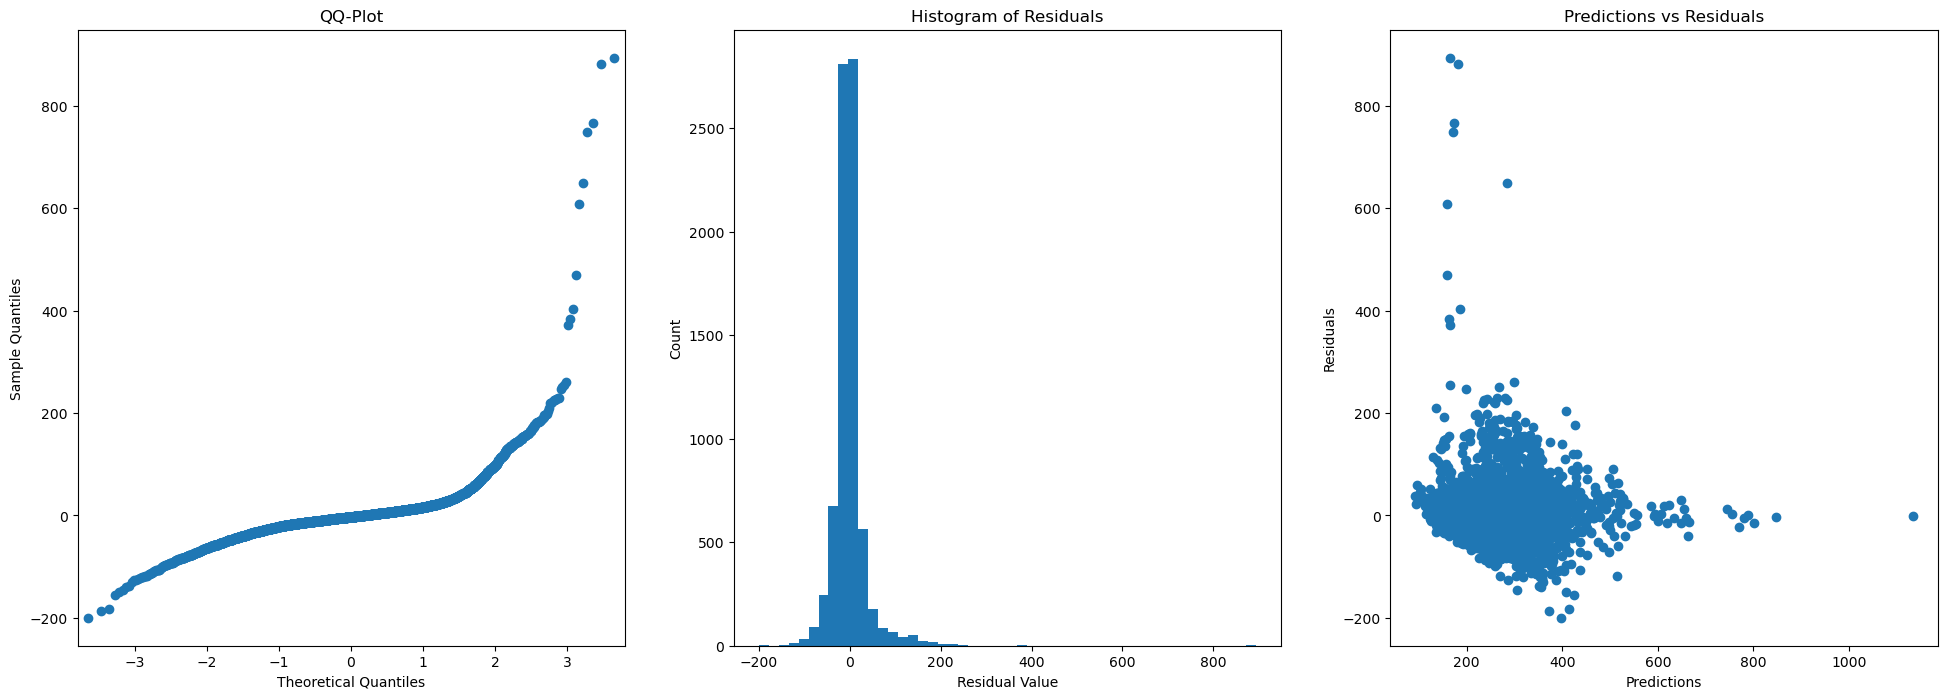

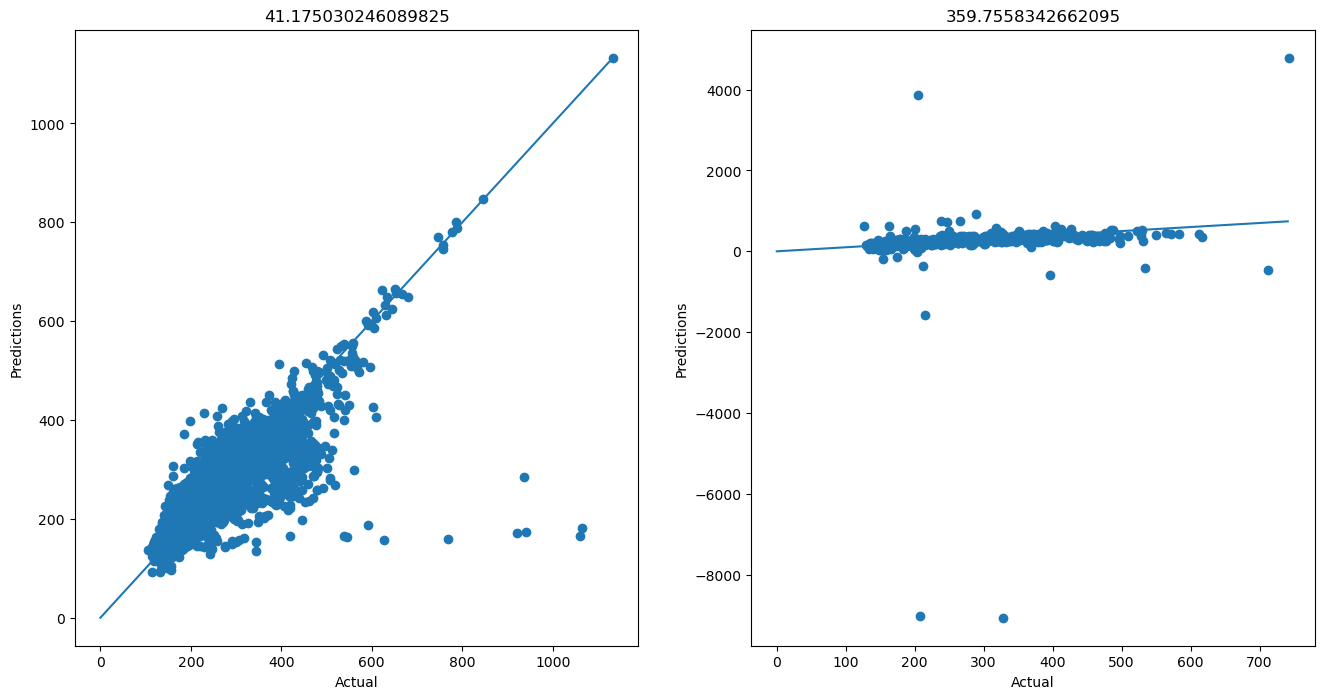

In [35]:
X_poly_dummies = numpy.concatenate([X_poly, dummies], axis=1)
print('Linear R**2 = ' + str(r2_score(Y[0:training_samples], model_poly.predict(X_poly_dummies[0:training_samples, :]))))
plot_diagnoistics(model_poly, model_poly.resid, X_poly_dummies[0:training_samples, :], Y[0:training_samples], 
                  X_poly_dummies[(training_samples + validation_samples):, :], Y[(training_samples + validation_samples):], show_line = False)

Ridge R**2 = 0.7170378455676993


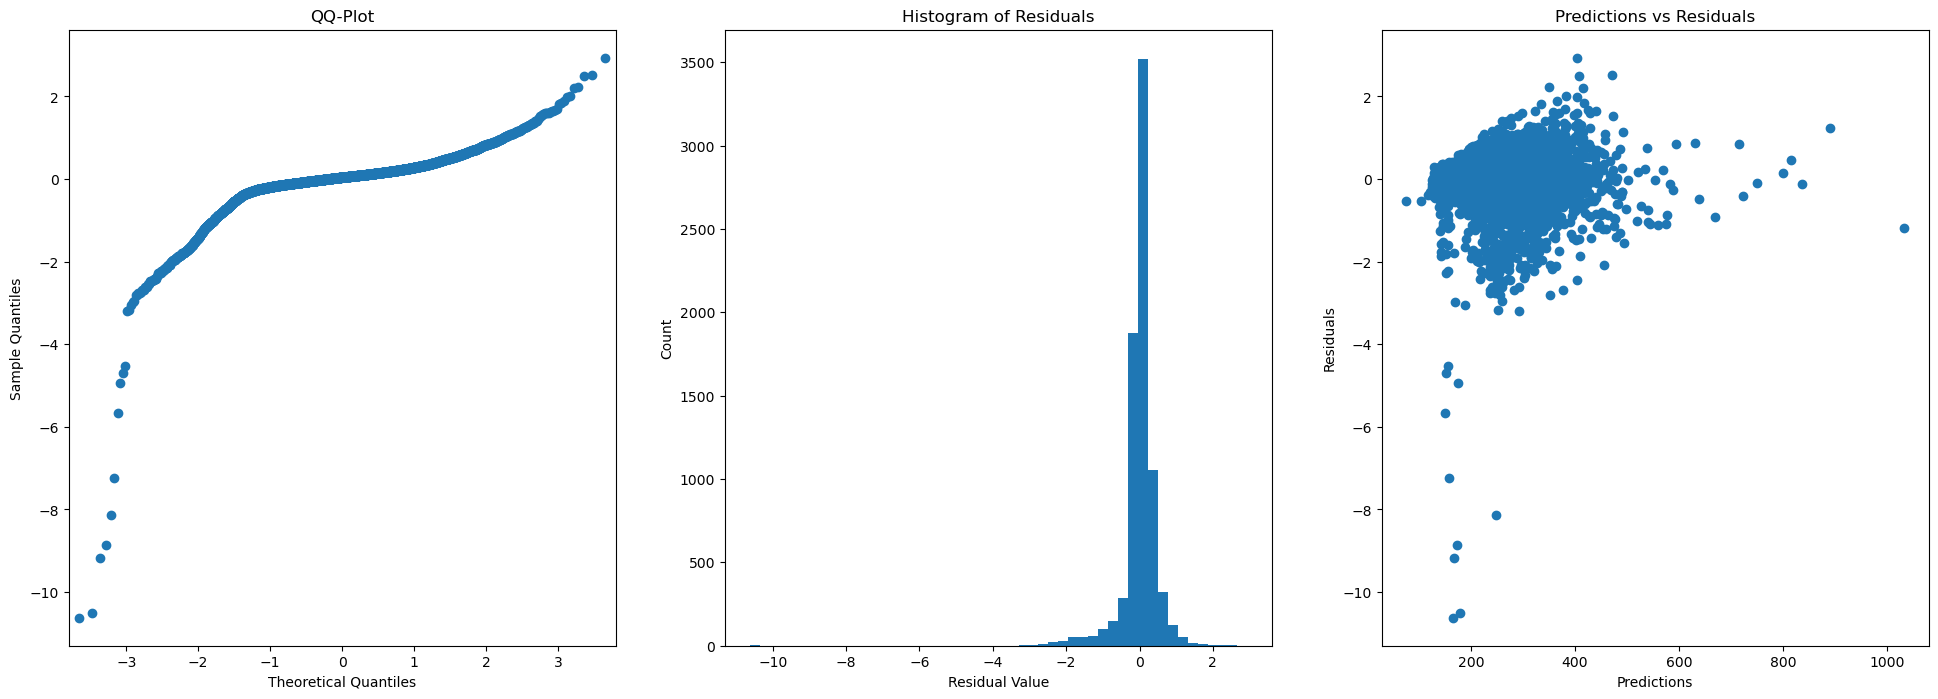

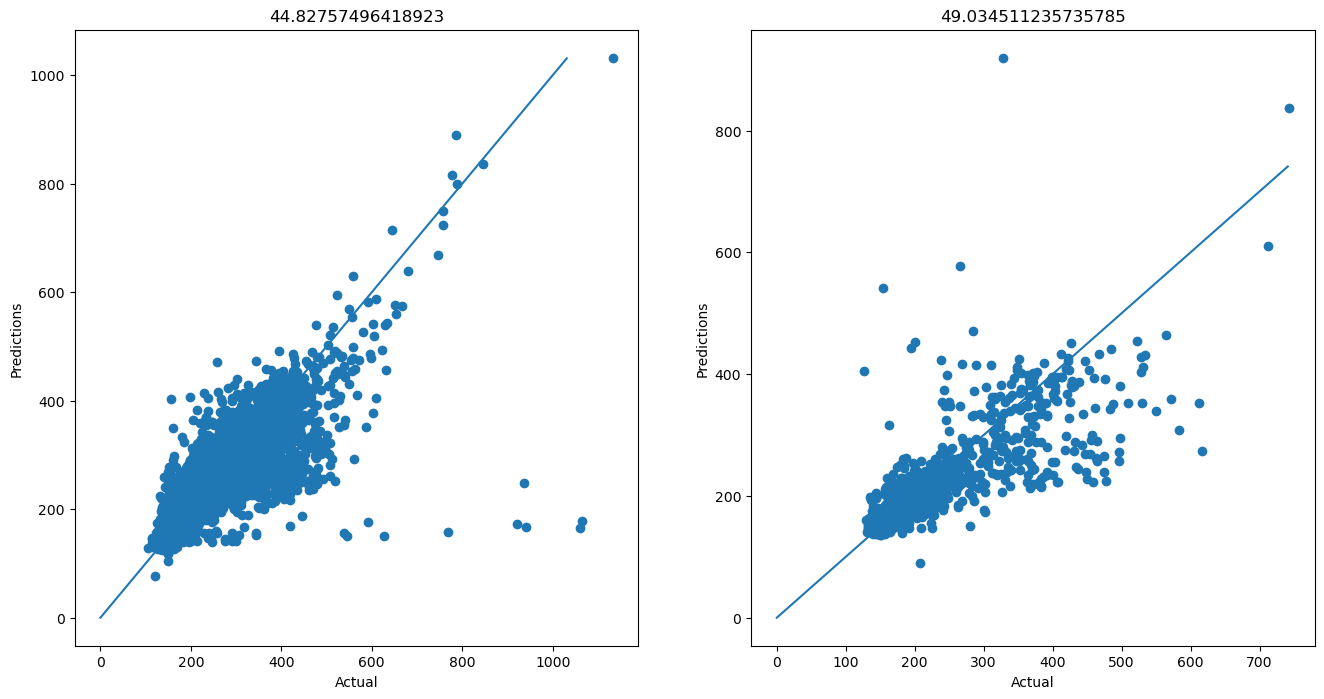

In [36]:
print('Ridge R**2 = ' + str(r2_score(Y_train, trained_model_poly_ridge.predict(X_train_poly))))
plot_diagnoistics(trained_model_poly_ridge, trained_model_poly_ridge.predict(X_train_poly) - Y_train, 
                  X_train_poly, Y_train, X_test_poly, Y_test, show_line = False, show_scatter = True, Y_sigma = Y_sigma, Y_mu = Y_mu)

Lasso R**2 = 0.7001392428853026


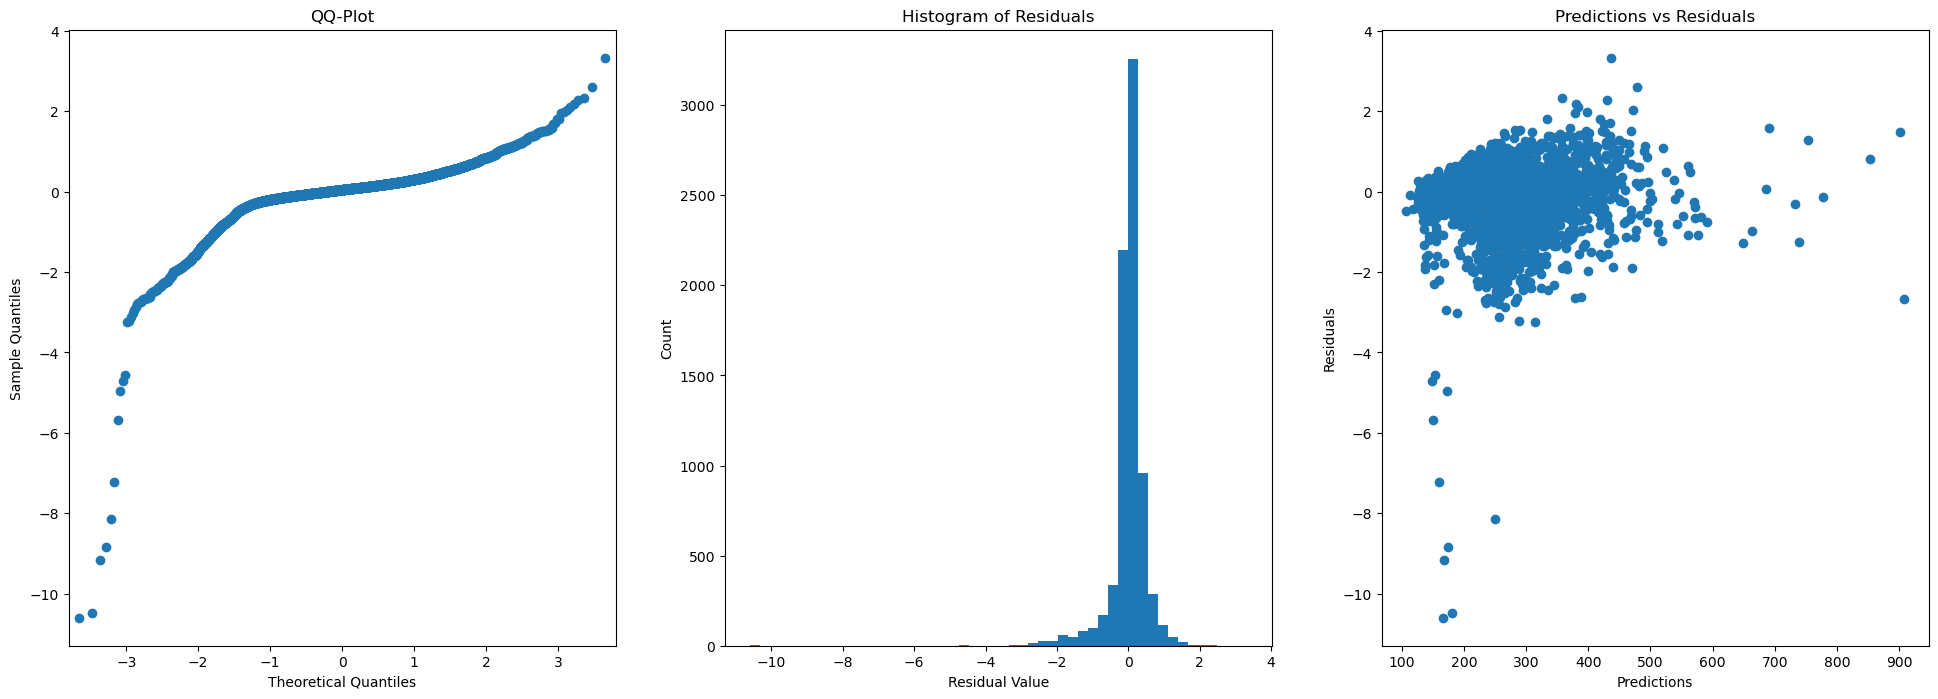

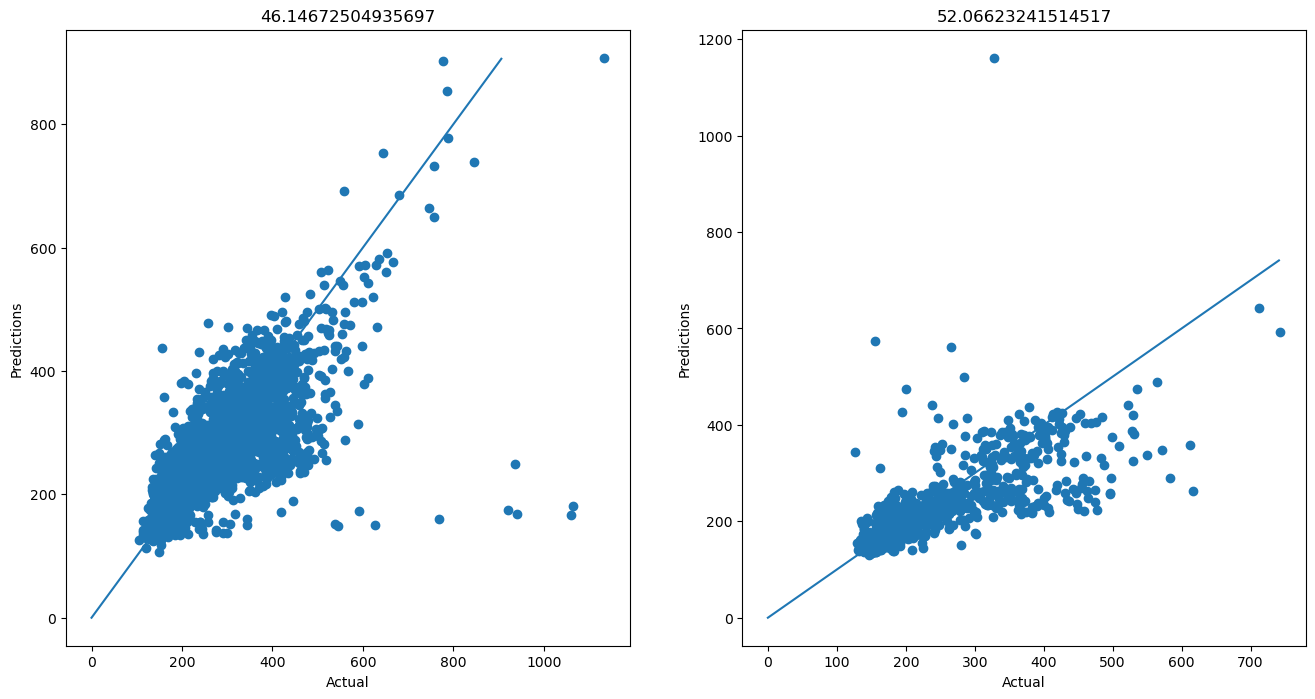

In [37]:
print('Lasso R**2 = ' + str(r2_score(Y_train, trained_model_poly_lasso.predict(X_train_poly))))
plot_diagnoistics(trained_model_poly_lasso, trained_model_poly_lasso.predict(X_train_poly) - Y_train, 
                  X_train_poly, Y_train, X_test_poly, Y_test, show_line = False, show_scatter = True, Y_sigma = Y_sigma, Y_mu = Y_mu)

From these plots and $R^2$ values, and comparing to the linear model above, we can see that regularisation has not magically made everything better.

In fact, what we see is that our $R^2$ values are worse, yet the model performs better on the test set. This may seem odd, but remember that $R^2$ considers the quality of fit to the training set. While we want a high $R^2$, we also wish to avoid overfitting. Ultimatley the way to maximse $R^2$ is to have a perfect fit to the training data, which in many practical cases is sadly likely to indicate over fitting. This however does not mean that $R^2$ is of no use, it just needs to be considered in combination with other details such as performance on test sets.

## Final Thoughts

So what have we learned today?

Regaularised regression gives us a way to deal with large input spaces (i.e. lots of variables) and improve performance without the need to manually identify and remove poor or duplicate variables. However, it's not a silver bullet and does not guarantee amazing performance. Consider our initial model (using just the 8 counters and the time) - that model is still more accurate than our final ridge and lasso models; though ridge and lasso made a large difference when considering the greatly expanded input space with the higher order terms. We could also improve ridge and lasso a bit more too by conducting a more fine-grained search for $\lambda$, if we wanted.

Comparing ridge and lasso, the formulation is very similar, but the end result is quite different. Ridge will supress terms, lasso can outright eliminate them by setting weights to 0. Even with a massive value of $\lambda$ ridge can't get terms to 0 (though they will get increasingly close). For regularisation, standardising data (subtract the mean, divide by the standard deviation) can help deal with the scale difference between dimensions. It also makes visualisation easier with the trace plots. Finally, for Lasso and Ridge, our usual analysis methods of qqplots, and so on are valid, but we don't have p-values.

#### Selecting $\lambda$

In this example we've used pretty coarse estimations for $\lambda$. Using a smaller step size will lead to a more accurate model, but will probably also take a long, long time to run. If you want to be more accurate, consider an iterative approach, i.e:
* Start with a coarse search range, find some initial best estimate.
* Now conduct a fine search around that initial estimate.
* You now, if you were really keen, go again in a range around the current best estimate.

If you use a linear range, this process is really easy. If you use a log-scale range, this process is slightly harder (only slightly) as you will need to remember to take whatever value you get as your estimate of lambda, and take the log of it before feeding this back into to get a new log-scale range.

Even with the above though, you still need to make an initial esimate of $\lambda$, and there are a couple of things to note. If you determine that your best value is $0$, this means that regularisation is not helping. This may actually be a valid result, but may also indicate that the first non-zero values you're looking at are too big, i.e. the first non-zero value of $\lambda$ may be applying too much regularisation. Try reducing this to a much smaller value and search at values very near 0, and confirm that even a very small amount of regularisation has no positive impact.

The other thing you may find is that your best value of $\lambda$ is the last one you check, i.e. you search from $0$ to $100$ and find $\lambda = 100$ is best. It's possible (even likely) that a large value of $\lambda$ will be better still. Try increasing the search range to find the point at which the validation accuracy reaches a minimum.

#### Notation

Finally some notes on notation. The regularisation term we use for lasso regression, $\sum_{j=0}^p |w_j|$, is oftern refered to as an L1 Norm, and may also be written as $||w_j||_1$. Similarly, the ridge regression term, an L2 norm, may be written as $||w_j||_2$. 

The other norm that you may encounter in machine learning is the L0 norm, $||w_j||_0$. This is actually the number of non-zero elements in the vector and this cannot be directly optimised for. Thus while you may see the L0 norm appear in theory in some places (sparse coding for example), in practice it is usually approximated by the L1 norm.